In [1]:
import biom
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as ss
from skbio.stats.composition import clr
from sklearn.metrics import balanced_accuracy_score, make_scorer, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

from helper import tool_text_styling_dict, tool_palette

plt.style.use("./paper.mplstyle")

In [2]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

md = pd.read_table("../data/tcga/processed/processed_md.2.tsv", sep="\t", index_col=0)
md["investigation"] = md["investigation"].str.replace("TCGA-", "")
print(md.shape)
invest_labels = pd.Series(
    LabelEncoder().fit_transform(md["investigation"]),
    index=md.index
)
center_labels = pd.Series(
    LabelEncoder().fit_transform(md["data_submitting_center_label"]),
    index=md.index
)

(1124, 41)


In [3]:
md.columns

Index(['sample_name', 'run_prefix', 'experimental_strategy', 'cgc_base_name',
       'filename', 'analyte_amount', 'analyte_A260A280Ratio',
       'aliquot_concentration', 'cgc_id', 'cgc_filename', 'vital_status',
       'gender', 'race', 'ethnicity', 'disease_type', 'data_subtype',
       'tcga_sample_id', 'cgc_case_uuid', 'sample_type', 'cgc_platform',
       'gdc_file_uuid', 'primary_site', 'age_at_diagnosis', 'cgc_sample_uuid',
       'cgc_aliquot_uuid', 'tcga_aliquot_id', 'reference_genome',
       'tcga_case_id', 'investigation', 'days_to_death', 'knightlabID',
       'data_submitting_center_label', 'tissue_source_site_label',
       'country_of_sample_procurement', 'portion_is_ffpe',
       'pathologic_t_label', 'pathologic_n_label',
       'histological_diagnosis_label', 'pathologic_stage_label', 'PlateCenter',
       'PlateCenterFlag'],
      dtype='object')

In [4]:
centers_short_map = {
    "Washington University School of Medicine": "WUSTL",
    "Broad Institute of MIT and Harvard": "BI",
    "Baylor College of Medicine": "BCM",
    "Harvard Medical School": "HMS",
    "MD Anderson - Institute for Applied Cancer Science": "MDA"
}

In [5]:
investigations = [x for x in md["investigation"].value_counts().index if x != "BRCA"]
len(investigations)

18

In [6]:
tbl = biom.load_table("../data/tcga/processed/species/processed_tbl.bacteria.2.biom")

In [7]:
tbl.shape

(2302, 1124)

In [8]:
centers = md["data_submitting_center_label"].unique()

center_pal = dict(zip(
    centers,
    sns.color_palette("colorblind", len(centers))
))

/home/grahman/miniconda3/envs/birdman-analyses-final/lib/python3.8/site-packages/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))
/home/grahman/miniconda3/envs/birdman-analyses-final/lib/python3.8/site-packages/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))
/home/grahman/miniconda3/envs/birdman-analyses-final/lib/python3.8/site-packages/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))
/home/grahman/miniconda3/envs/birdman-analyses-final/lib/python3.8/site-packages/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))
/home/grahman/miniconda3/envs/birdman-analyses-final/lib/python3.8/site-packages/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))
/home/grahman/m

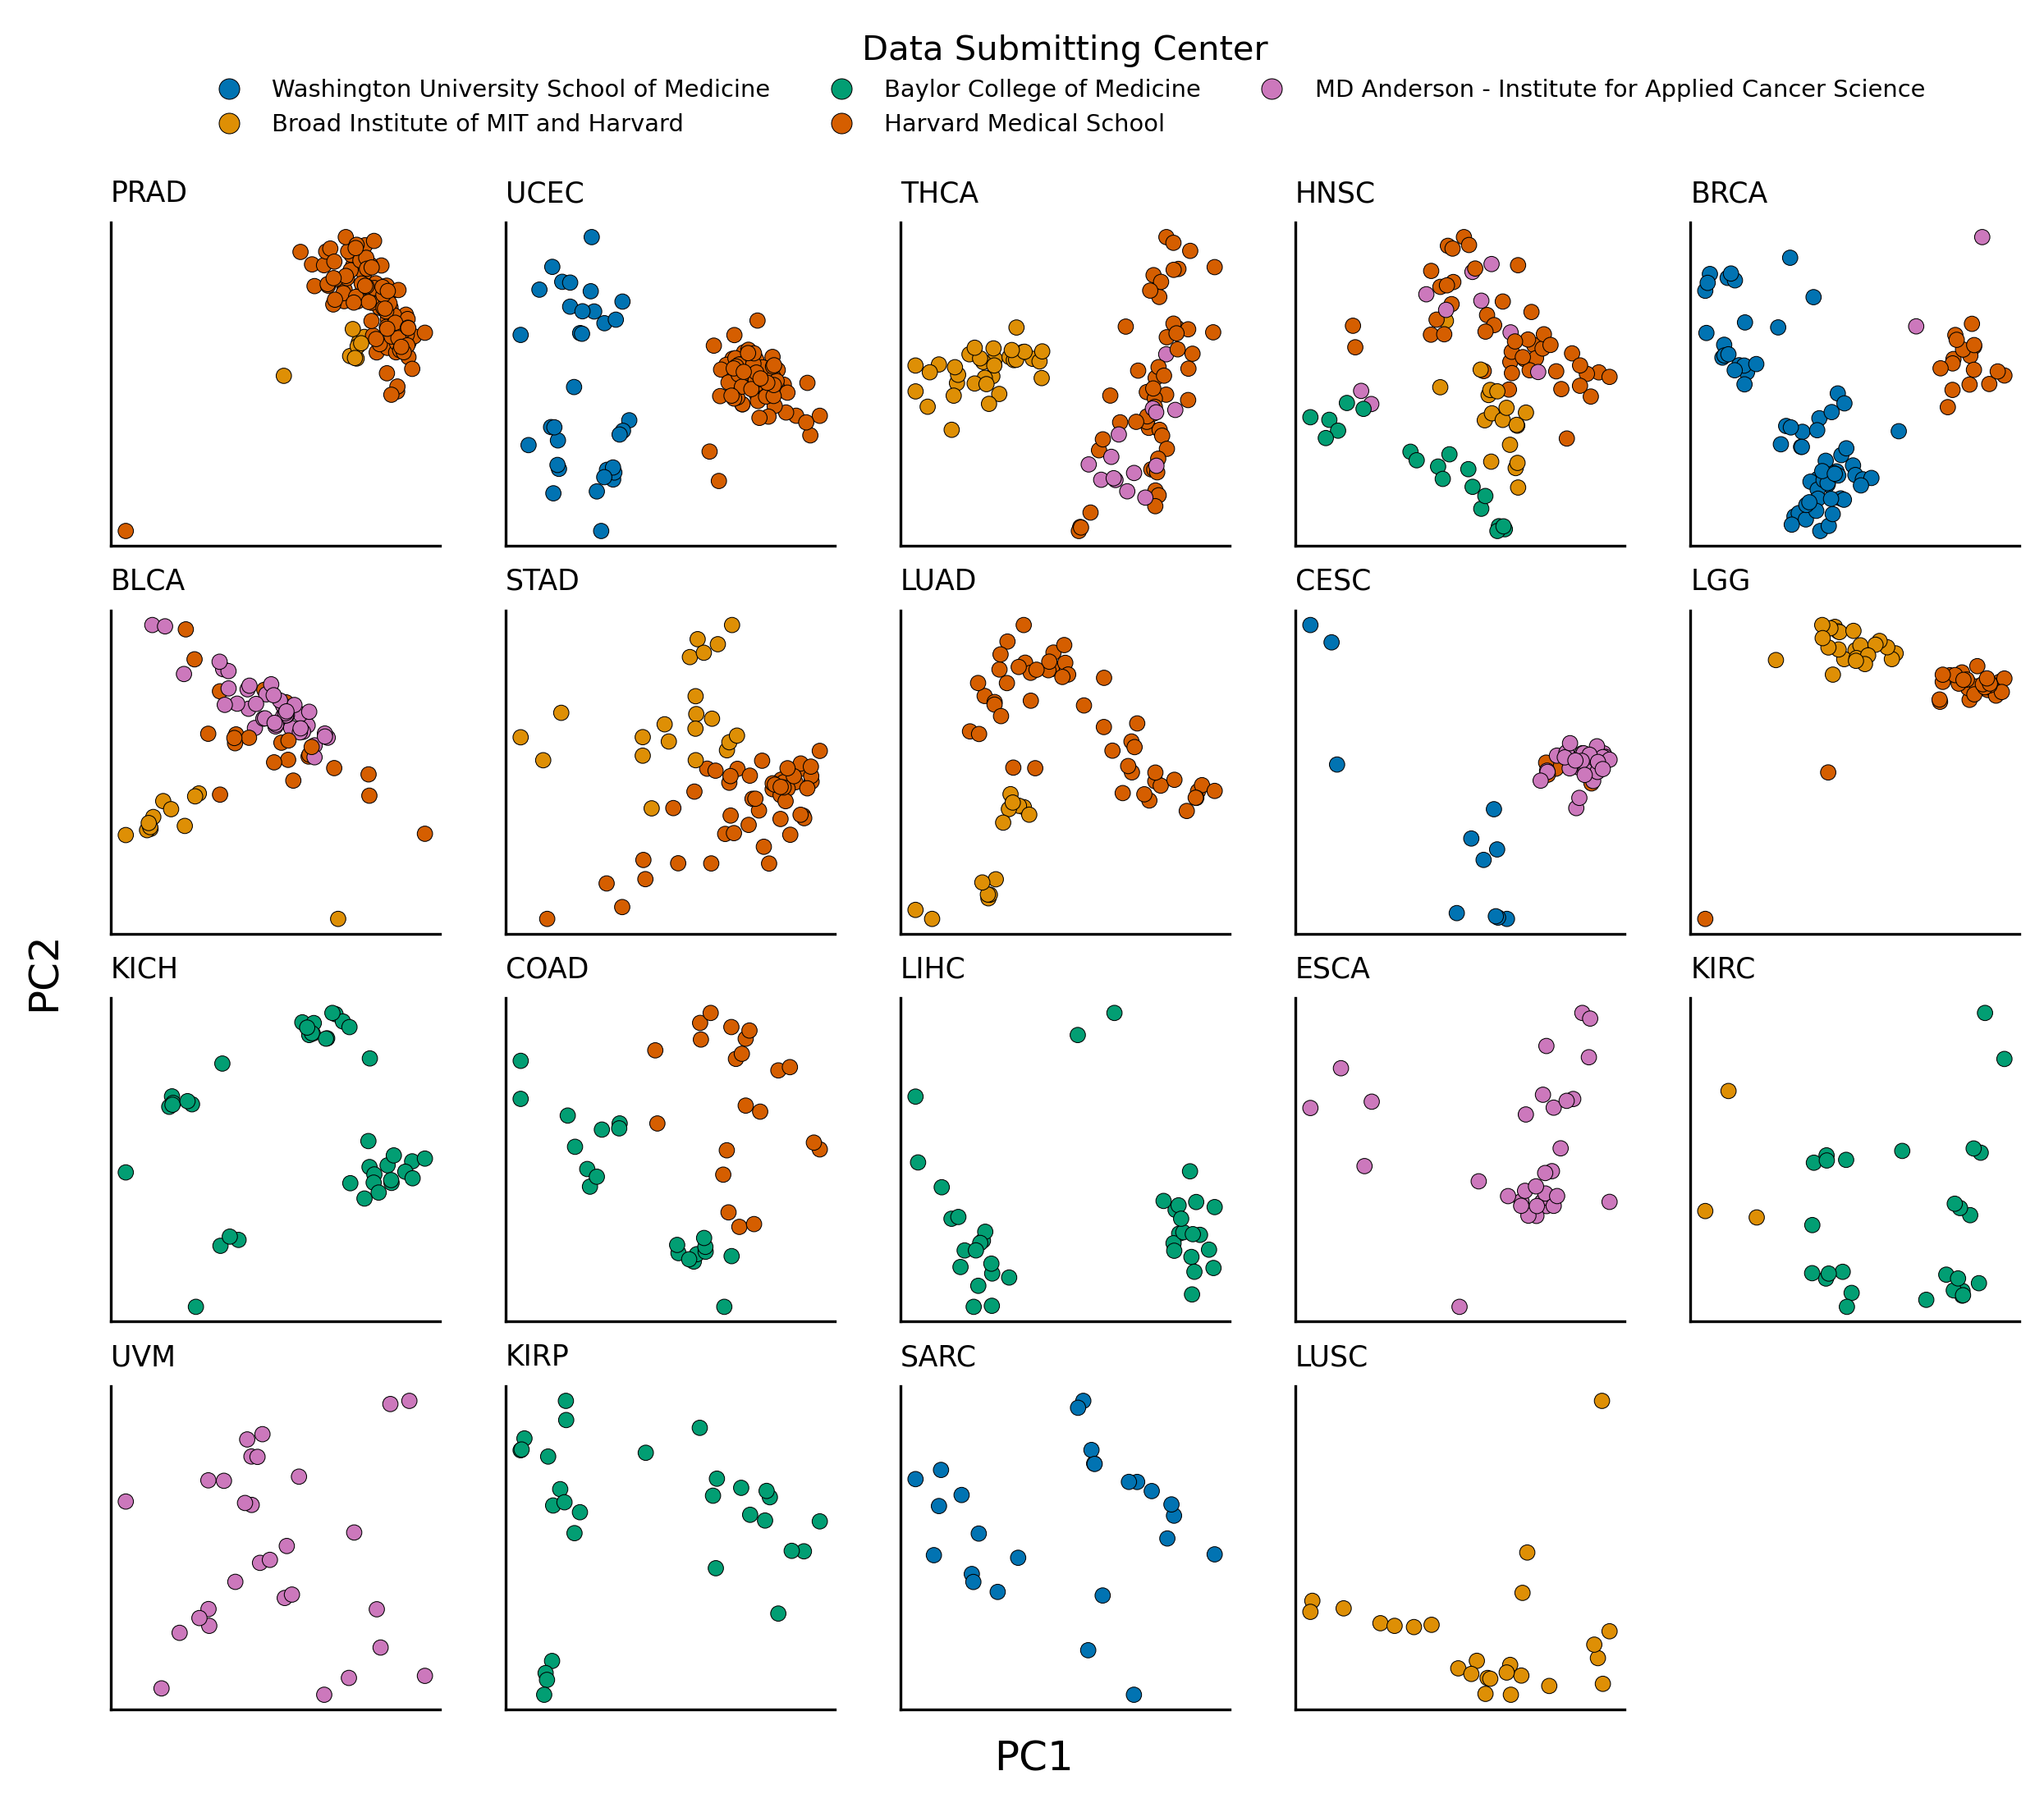

In [9]:
from gemelli.rpca import rpca

fig = plt.figure(figsize=(10, 8))
axs = []

for i, invest in enumerate(md["investigation"].value_counts().index, start=1):
    idx = md[md["investigation"] == invest].index
    tbl_filt = tbl.filter(idx, inplace=False)
    tbl_filt.remove_empty()
    
    ord_res, dm = rpca(tbl_filt)
    samp_axes = ord_res.samples.join(md, how="inner")
    
    ax = fig.add_subplot(4, 5, i)
    sns.scatterplot(
        data=samp_axes,
        x="PC1",
        y="PC2",
        hue="data_submitting_center_label",
        palette=center_pal,
        legend=False,
        linewidth=0.25,
        edgecolor="black",
        s=20,
        ax=ax
    )

    ax.set_title(invest, fontsize="small")
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    axs.append(ax)
    
from matplotlib.lines import Line2D

handles = []
for center, color in center_pal.items():
    handle = Line2D([0], [0], color=color, label=center, marker="o",
                    lw=0, mew=0.25, mec="black")
    handles.append(handle)
    
axs[2].legend(
    handles=handles,
    ncol=3,
    loc="lower center",
    bbox_to_anchor=[0.5, 1.2],
    frameon=False,
    title="Data Submitting Center"
)

fig.supylabel("PC2", x=0.09)
fig.supxlabel("PC1", y=0.09)
    
plt.savefig("../figures/tcga/cancer_type_rpca.pdf")
plt.show()

In [10]:
full_ord_res, full_dm = rpca(tbl, n_components=5)
full_samples = full_ord_res.samples.join(md)

/home/grahman/miniconda3/envs/birdman-analyses-final/lib/python3.8/site-packages/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


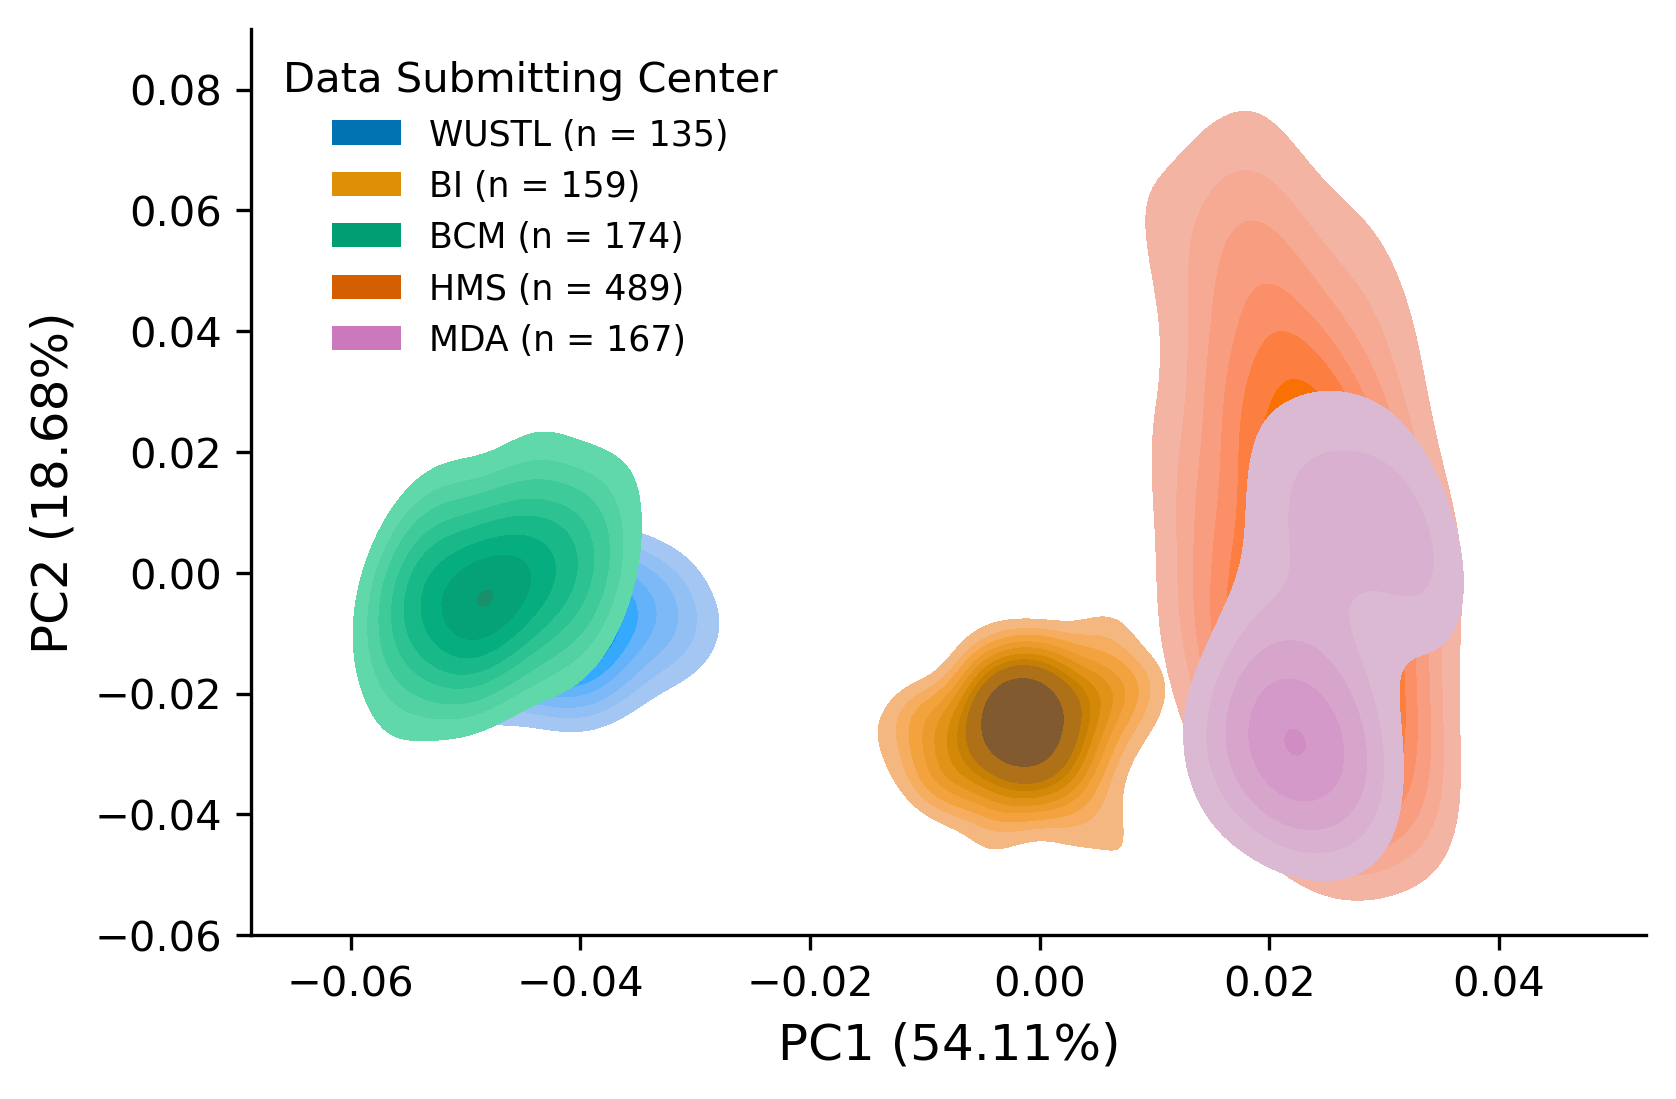

In [11]:
fig, ax = plt.subplots(1, 1)

sns.kdeplot(
    data=full_samples,
    x="PC1",
    y="PC2",
    hue="data_submitting_center_label",
    fill=True,
    palette=center_pal,
    thresh=0.2,
    legend=False,
    ax=ax
)

ax.set_ylim([-0.06, 0.09])

from matplotlib.patches import Patch

handles = []
for center, center_short in centers_short_map.items():
    n = len(md[md["data_submitting_center_label"] == center])
    p = Patch(
        facecolor=center_pal[center],
        label=f"{center_short} (n = {n})"
    )
    handles.append(p)
    
ax.legend(
    handles=handles,
    loc="upper left",
    title="Data Submitting Center",
    fontsize="small",
    frameon=False
)

prop_exp = full_ord_res.proportion_explained * 100
ax.set_xlabel(f"PC1 ({prop_exp[0]:.2f}%)")
ax.set_ylabel(f"PC2 ({prop_exp[1]:.2f}%)")

plt.savefig("../figures/tcga/full_rpca_center.pdf")
plt.show()

In [12]:
import re

invest_reg = re.compile("\[T.TCGA-(\w+)\]_(mean|std)")

In [13]:
def rename_invest_cols(x):
    invest, agg_type = invest_reg.search(x).groups()
    return "_".join([invest, agg_type])

summ_diff_raw = pd.read_table("../results/tcga/species/birdman_results.bacteria.2.tsv", sep="\t", index_col=0)
summ_diff = summ_diff_raw.filter(like="TCGA")
summ_diff = summ_diff.rename(columns=rename_invest_cols)
summ_diff.index = summ_diff.index.astype(str)
summ_diff.head()

BLCA_mean  CESC_mean  COAD_mean  ESCA_mean  HNSC_mean  KICH_mean  \
Feature                                                                        
G000143845  -1.076777   0.429463   0.659927   3.286459   5.279673   0.363183   
G009740265  -0.705101  -2.662072   2.803963   1.322989   1.072876   0.919733   
G002370355   1.177119  -0.647524  -3.407568  -1.585086   0.703871  -2.347963   
G001042675  -3.012375  -0.203799  -3.342081   2.401584   3.227162   0.712793   
G000284255  -0.513025  -2.128528   2.727296  -1.076555   0.599714   0.233945   

            KIRC_mean  KIRP_mean  LGG_mean  LIHC_mean  ...   LGG_std  \
Feature                                                ...             
G000143845   0.901009   1.558132 -2.257828   0.325224  ...  3.067291   
G009740265   1.220398   1.036483  1.572532   1.215891  ...  2.463396   
G002370355   0.913753   0.032247  0.644858   1.017276  ...  2.563343   
G001042675   1.403987   2.457508 -2.183884   0.872609  ...  3.276169   
G000284255   0.850228  -2.389894  1.337389  -2.727587  ...  2.225297   

            LIHC_std  LUAD_std  LUSC_std  PRAD_std  SARC_std  STAD_std  \
Feature                                                                  
G000143845  2.784021  2.946356  3.398437  3.143958  3.400918  2.227340   
G009740265  2.659075  3.088532  3.508254  3.288815  3.072347  2.290449   
G002370355  2.711329  2.931985  3.339980  3.005388  2.548292  2.177111   
G001042675  2.713204  2.488785  3.349009  3.183500  2.521516  2.289744   
G000284255  3.261608  2.122095  2.626535  2.434110  3.554600  2.279388   

            THCA_std  UCEC_std   UVM_std  
Feature                                   
G000143845  2.860714  2.944276  3.298936  
G009740265  3.008559  2.338097  3.375193  
G002370355  2.258369  2.040992  3.524083  
G001042675  2.316043  2.178537  3.526639  
G000284255  2.023715  2.260910  3.812598  

[5 rows x 36 columns]

In [14]:
summ_diff.shape

(2302, 36)

In [15]:
summ_diff_cent = summ_diff.filter(like="mean")
summ_diff_cent = summ_diff_cent.apply(lambda x: x - x.mean(), axis=0)
summ_diff_cent = summ_diff_cent.rename(columns=lambda x: x.replace("_mean", ""))
summ_diff_cent.head()

BLCA      CESC      COAD      ESCA      HNSC      KICH  \
Feature                                                                  
G000143845 -0.244104  1.212297 -0.755431  2.967919  3.888750  0.007588   
G009740265  0.127573 -1.879238  1.388604  1.004450 -0.318047  0.564138   
G002370355  2.009793  0.135310 -4.822927 -1.903626 -0.687051 -2.703558   
G001042675 -2.179702  0.579035 -4.757440  2.083044  1.836239  0.357198   
G000284255  0.319649 -1.345694  1.311938 -1.395095 -0.791208 -0.121650   

                KIRC      KIRP       LGG      LIHC      LUAD      LUSC  \
Feature                                                                  
G000143845  0.332989  1.237032 -1.802574  0.359519 -1.976791 -1.750772   
G009740265  0.652379  0.715384  2.027786  1.250187 -1.714187 -1.241196   
G002370355  0.345734 -0.288853  1.100112  1.051571 -1.757795 -2.362929   
G001042675  0.835968  2.136408 -1.728631  0.906905  1.434134 -1.563993   
G000284255  0.282209 -2.710994  1.792643 -2.693292  2.953172  1.457071   

                PRAD      SARC      STAD      THCA      UCEC       UVM  
Feature                                                                 
G000143845 -1.319163 -1.638461  2.909206 -2.027297 -3.393146 -0.101788  
G009740265 -0.880759 -2.683375  1.870487 -1.946919 -1.694939 -0.553125  
G002370355 -1.235842  2.412882  1.310313  2.299523  2.413938  0.350209  
G001042675 -0.830805  3.099220  3.222855  1.264295  0.521217 -0.137474  
G000284255  0.772277 -0.829322 -1.402391  1.812744  1.003010  0.779849

/home/grahman/miniconda3/envs/birdman-analyses-final/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


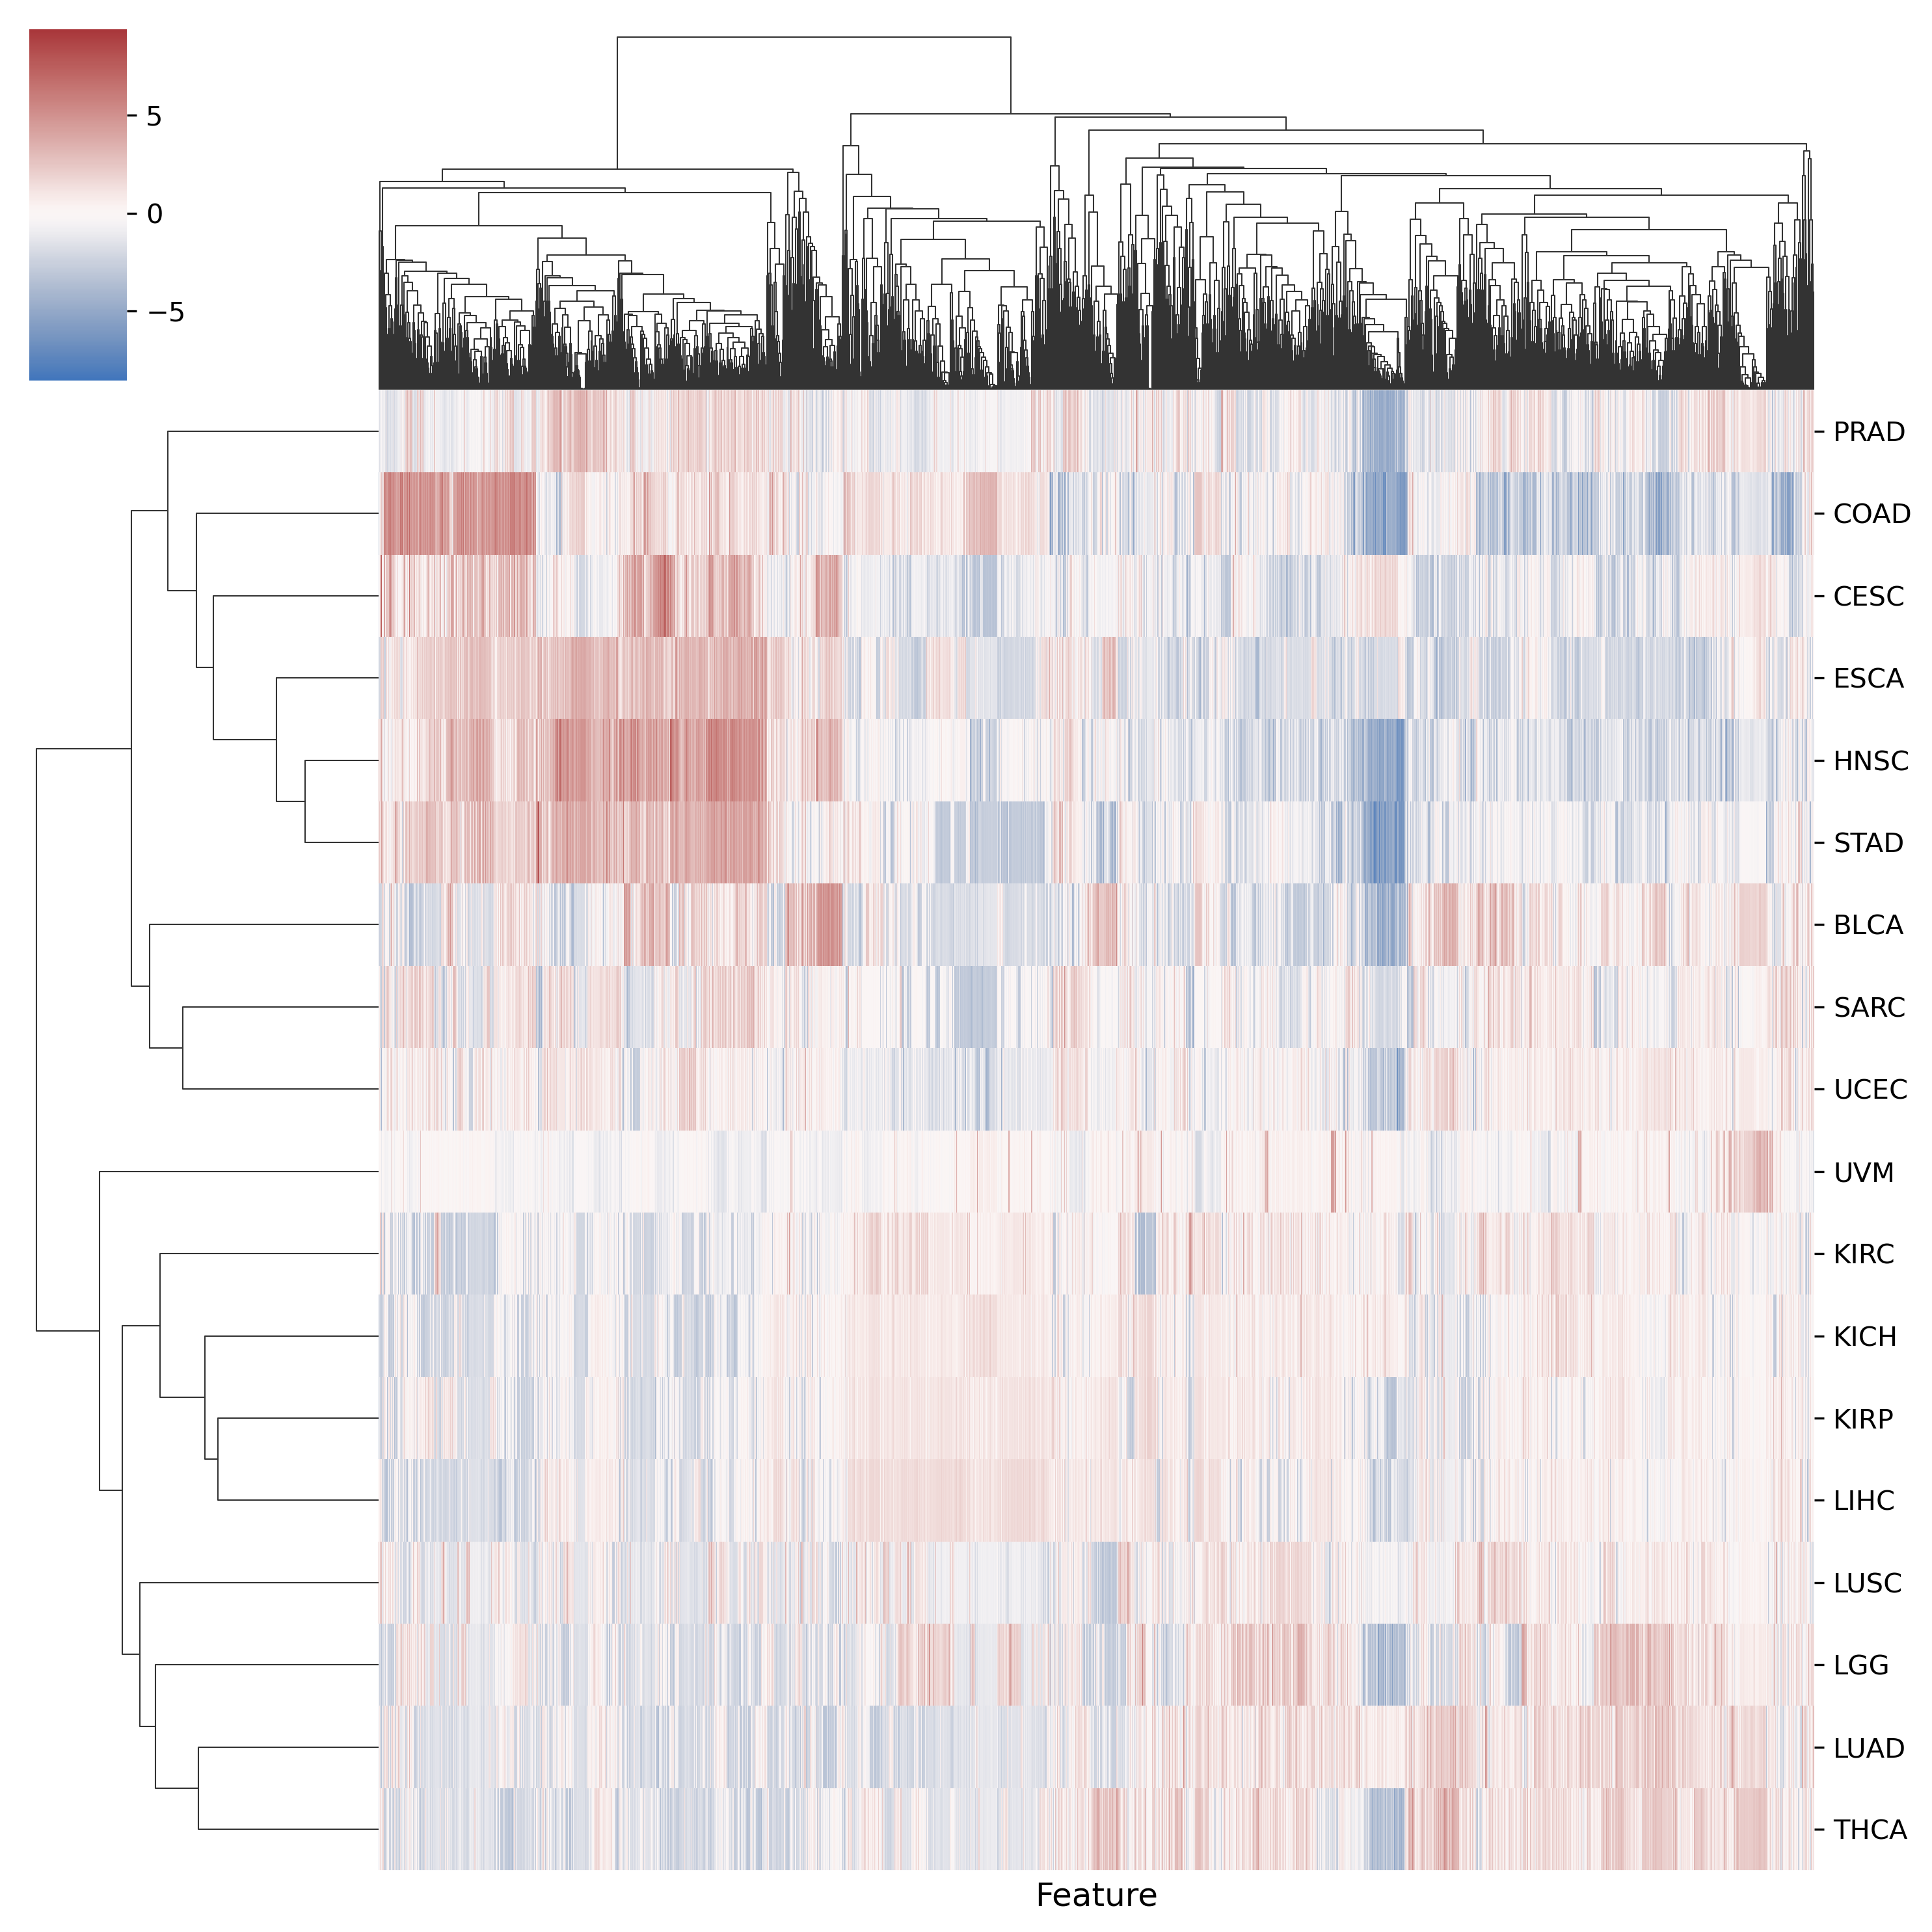

In [16]:
sns.clustermap(
    summ_diff_cent.T,
    cmap="vlag",
    center=0,
    metric="correlation",
    xticklabels=False,
    #z_score=0,
    #vmin=-10,
    #vmax=10
)

plt.savefig("../figures/tcga/cancer_diff_clustermap.pdf")
plt.show()

In [17]:
corr = summ_diff_cent.corr("kendall")
mask = np.zeros_like(corr)
np.fill_diagonal(mask, 1)

corr.iloc[:5, :5]

BLCA      CESC      COAD      ESCA      HNSC
BLCA  1.000000  0.119486 -0.014676  0.082720  0.128705
CESC  0.119486  1.000000  0.133701  0.273207  0.285946
COAD -0.014676  0.133701  1.000000  0.259562  0.348027
ESCA  0.082720  0.273207  0.259562  1.000000  0.484316
HNSC  0.128705  0.285946  0.348027  0.484316  1.000000

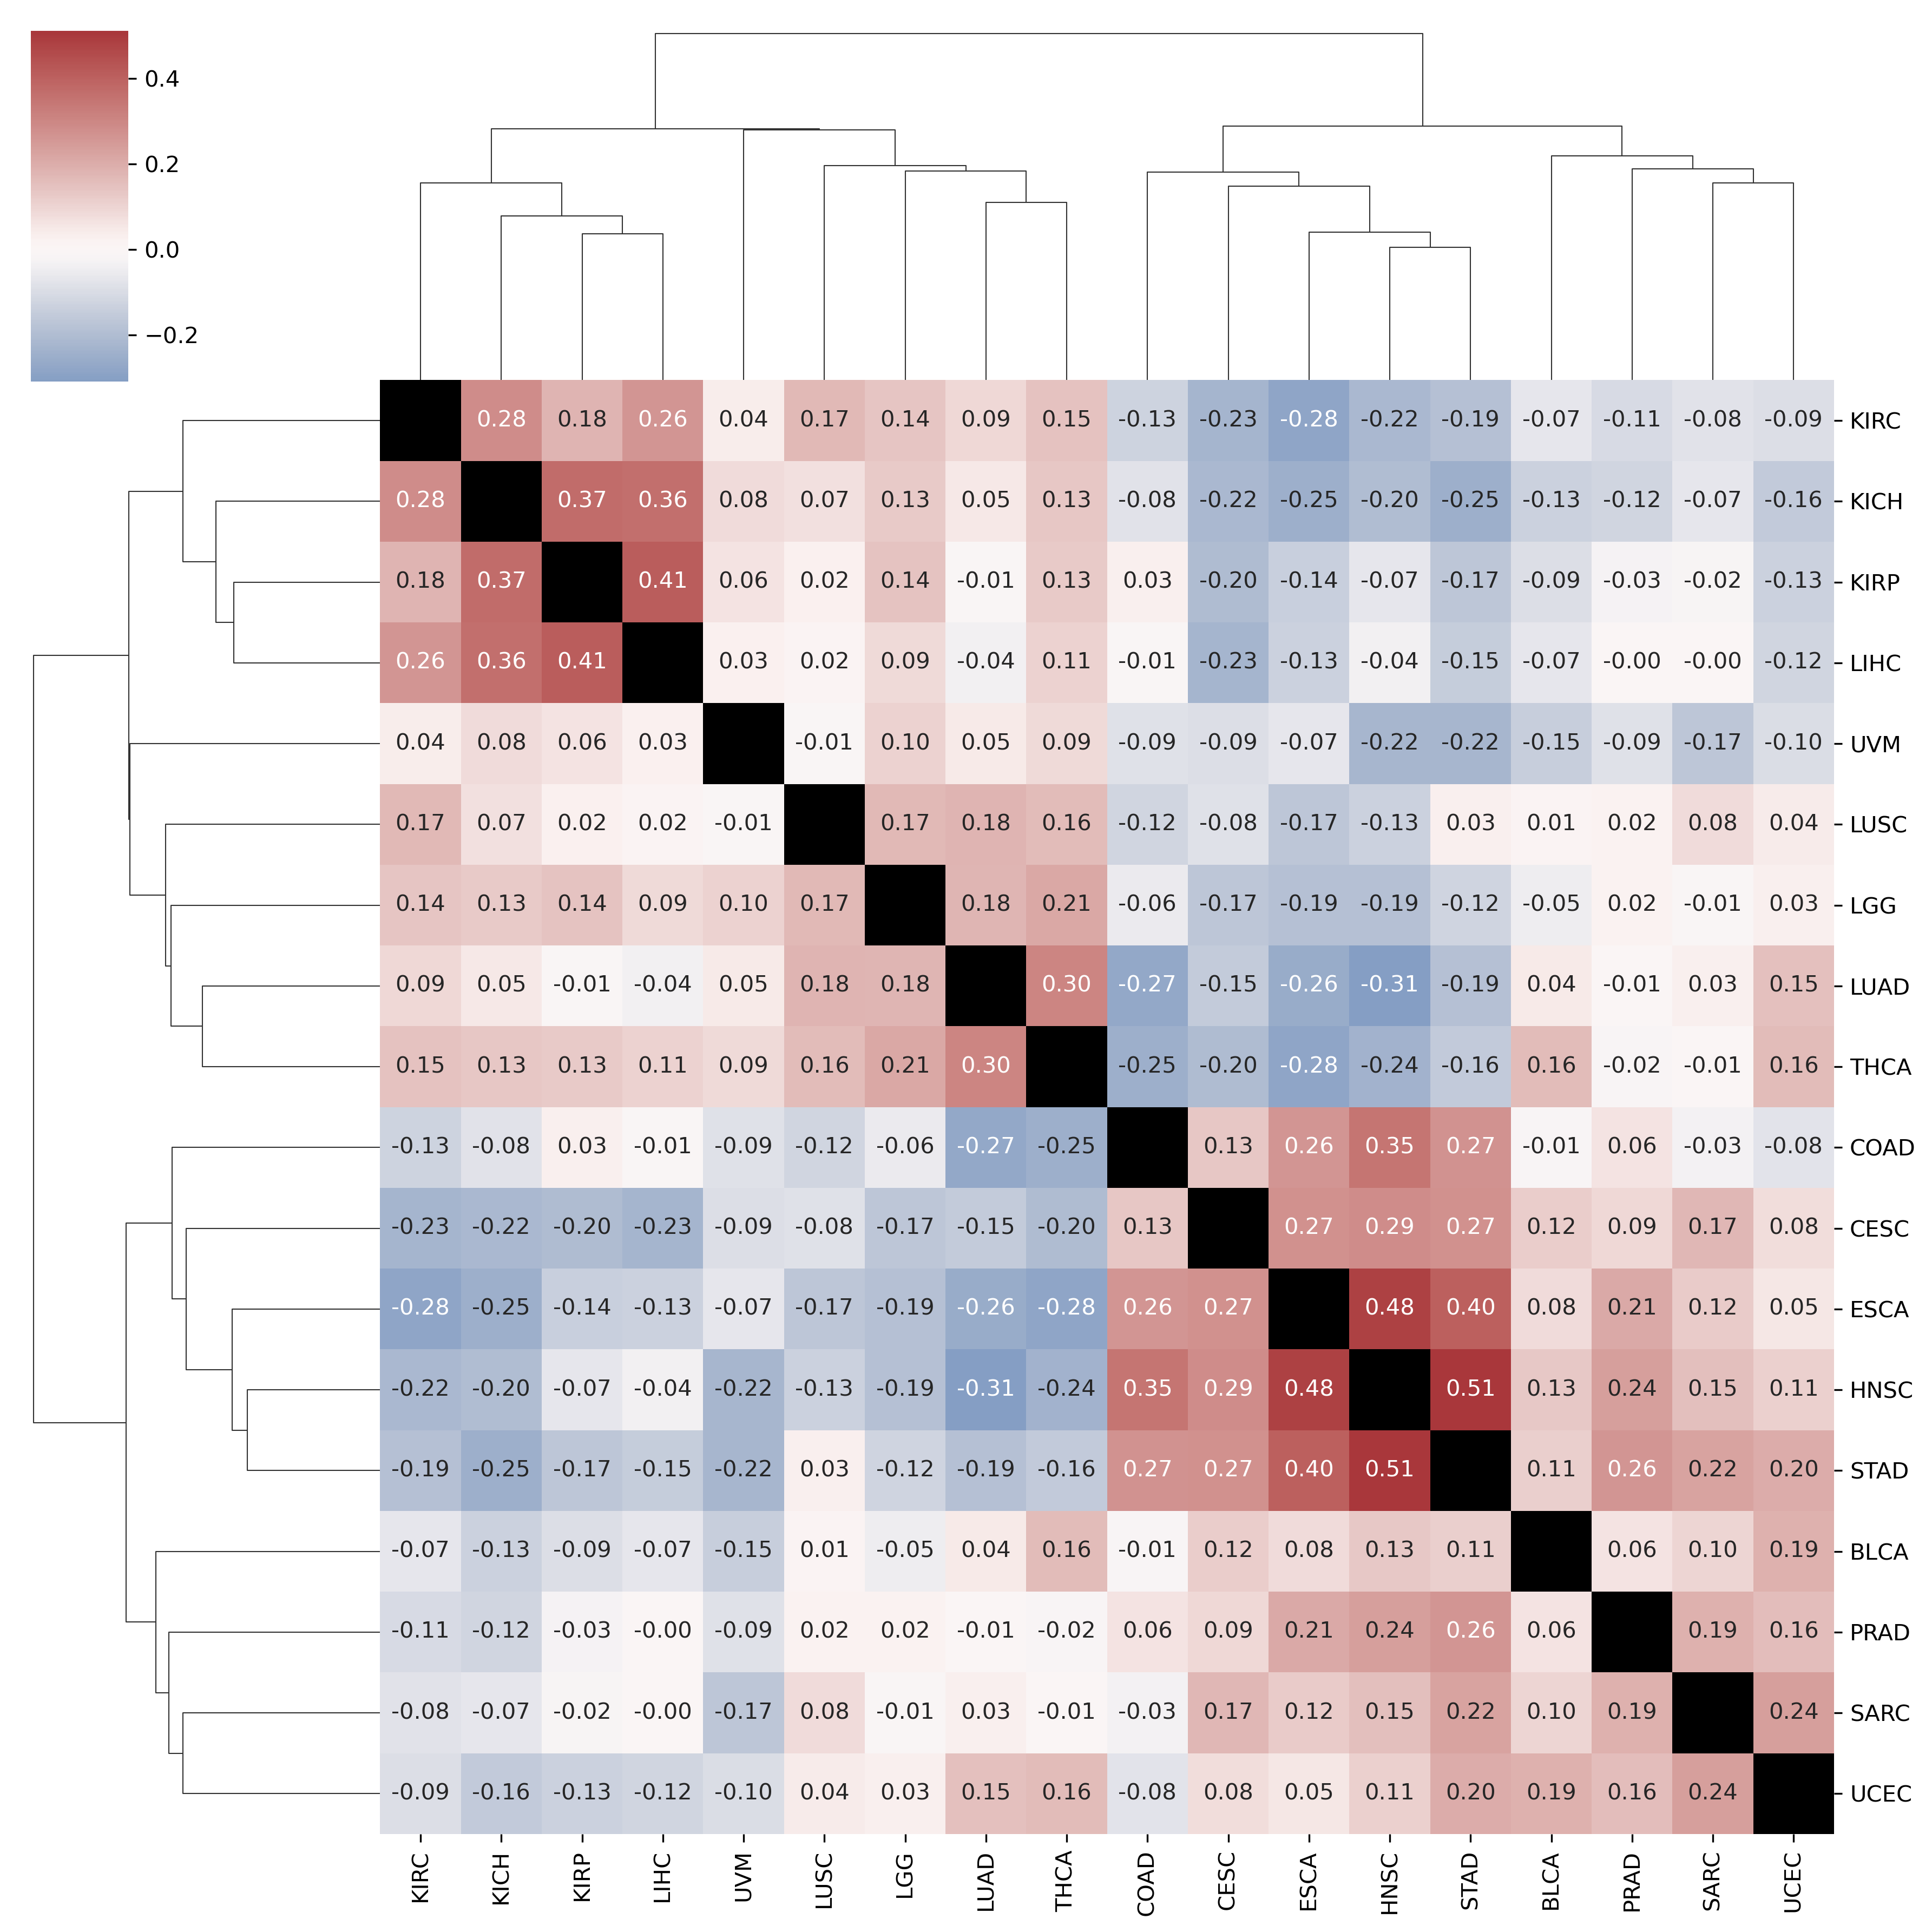

In [18]:
g = sns.clustermap(
    corr,
    cmap="vlag",
    center=0,
    annot=True,
    fmt=".2f",
    figsize=(12, 12),
    mask=mask,
    #dendrogram_ratio=0.2
)
g.ax_heatmap.set_facecolor("black")

plt.savefig("../figures/tcga/cancer_diff_correlation_clustermap.pdf")
plt.show()

In [19]:
tbl_df = tbl.to_dataframe(dense=True).T
table_clr = pd.DataFrame(clr(tbl_df.values + 1), index=tbl_df.index, columns=tbl_df.columns)

In [20]:
ancombc_res = pd.read_table("../results/tcga/ancombc_results_beta.2.tsv", sep="\t", index_col=0)
ancombc_res = ancombc_res.filter(like="investigation")
ancombc_res.columns = [x.replace("investigation", "") for x in ancombc_res.columns]
print(ancombc_res.shape)
ancombc_res.head()

(2302, 18)


BLCA      CESC      COAD      ESCA      HNSC      KICH  \
G000005845 -5.507995 -4.321303  0.262243 -5.931810 -3.995823  1.916829   
G000006605 -0.080484 -0.060323 -0.163516 -0.015236  0.018826 -0.030815   
G000006765 -0.472201 -0.195068  0.147681 -0.444889 -0.213397  0.167231   
G000006925 -5.209834 -4.059849  0.205585 -5.515525 -3.792808  1.776904   
G000006945 -2.155718 -1.592753 -0.174178 -2.109978 -1.549265  0.515091   

                KIRC      KIRP       LGG      LIHC      LUAD      LUSC  \
G000005845  2.011022  1.872404 -5.411231  2.664248 -5.147854 -5.051351   
G000006605  0.065618  0.142941 -0.129660  0.254207 -0.149330 -0.051162   
G000006765  1.148947 -0.180324 -0.103961 -0.486090 -0.227668  1.019306   
G000006925  1.933666  1.738372 -5.155696  2.532777 -4.974924 -4.928338   
G000006945  0.972953  0.656379 -2.167817  1.212503 -2.194100 -2.186626   

                PRAD      SARC      STAD      THCA      UCEC       UVM  
G000005845 -5.747608  1.804457 -5.233349 -5.304707 -3.642732 -5.763646  
G000006605 -0.090682  3.867061 -0.046945 -0.076329  0.134306 -0.044770  
G000006765 -0.201730 -0.266665  0.063220  0.021973 -0.392889 -0.329777  
G000006925 -5.384352  1.673420 -4.956858 -5.106877 -3.531615 -5.384032  
G000006945 -2.117967  0.358130 -2.109050 -2.169302 -1.566882 -2.053774

In [21]:
aldex2_regex = re.compile("model\.investigation([A-Z]+) Estimate")

aldex2_res = pd.read_table("../results/tcga/aldex2_results.2.tsv", sep="\t", index_col=0)
aldex2_res = aldex2_res.filter(like="investigation").filter(like="Estimate")
aldex2_res = aldex2_res.rename(columns=lambda x: aldex2_regex.search(x).groups()[0])
print(aldex2_res.shape)
aldex2_res.head()

(2302, 18)


BLCA      CESC      COAD       ESCA      HNSC      KICH  \
G000005845 -8.785664 -7.235786  0.189095 -10.147629 -7.106750  3.222472   
G000006605  0.353552  0.255046 -1.200260   0.329663 -0.290453 -0.244587   
G000006765 -0.755829  0.003470 -0.452929  -0.523525 -1.041276  0.367290   
G000006925 -8.400713 -6.888216  0.077566  -9.435584 -6.848989  3.066658   
G000006945 -4.428519 -3.217078 -0.838144  -4.431144 -3.863746  1.212870   

                KIRC      KIRP       LGG      LIHC      LUAD      LUSC  \
G000005845  3.144422  3.008665 -8.305769  4.152213 -7.490328 -7.024101   
G000006605 -0.047744  0.147342  0.346810  0.622413  0.059578  0.277802   
G000006765  2.197323 -0.654528  0.220142 -1.650587 -0.331147  2.481114   
G000006925  3.079778  2.873513 -8.075962  4.034893 -7.422764 -7.276082   
G000006945  1.586454  1.243731 -4.317882  2.179095 -4.641928 -4.721149   

                PRAD      SARC      STAD      THCA      UCEC       UVM  
G000005845 -9.421067  2.834849 -8.379088 -8.201421 -5.531672 -9.655811  
G000006605  0.368582  7.578187  0.134271  0.387395  0.611760  0.480630  
G000006765 -0.090398 -1.254242  0.024354  0.463117 -0.737238 -0.316217  
G000006925 -8.849940  2.691920 -8.075118 -8.097110 -5.569459 -9.062438  
G000006945 -4.262191  0.755986 -4.573222 -4.420094 -3.076824 -4.142594

In [22]:
import pathlib

deseq2_path = pathlib.Path("../results/tcga/deseq2.2/")
deseq2_invest_files = deseq2_path.glob("*.tsv")
deseq2_dfs = []

for f in deseq2_invest_files:
    invest = f.stem
    _df = pd.read_table(f, sep="\t", index_col=0)
    _df = _df["log2FoldChange"]
    _df.name = invest
    deseq2_dfs.append(_df)

deseq2_res = pd.concat(deseq2_dfs, axis=1)
print(deseq2_res.shape)
deseq2_res.head()

(2302, 18)


LUSC       PRAD      KIRP      STAD      HNSC      UCEC  \
G000005845  -9.974160 -13.953437  0.854852 -8.286147 -2.031937 -2.445319   
G000006605   0.208368   0.139123  1.225061 -0.011359  1.399926  2.186060   
G000006765   5.359700   4.146513  0.167747  3.788177  0.587490 -1.043066   
G000006925 -10.012184 -13.902231  0.756819 -7.932156 -2.125253 -2.442410   
G000006945  -5.829818  -5.432436  0.496743 -5.667532 -2.257478 -2.564562   

                BLCA        LGG      KIRC      LIHC       ESCA      THCA  \
G000005845 -8.535759 -10.063812  1.272307  1.463013 -15.738057 -9.265546   
G000006605 -0.703032   0.013165  0.194750  1.156102   1.126400 -0.001836   
G000006765 -1.568544   0.715394  3.977316 -1.459549  -0.792132  2.762695   
G000006925 -8.454179 -10.019158  1.293263  1.446027 -14.766755 -9.250072   
G000006945 -6.275622  -5.411698  1.040489  1.181952  -5.278901 -6.127629   

                 LUAD      CESC      KICH        UVM      SARC      COAD  
G000005845  -9.992529 -2.823469  0.518117 -25.133835 -0.452900 -0.357950  
G000006605  -0.940131  0.148105  0.189409   0.629520  7.226139 -1.388585  
G000006765   3.563725  0.156140  1.181028   0.057028 -0.316680  0.744779  
G000006925 -10.147580 -2.807079  0.434854 -22.680588 -0.509386 -0.336362  
G000006945  -6.314518 -2.590555  0.309534  -4.710926 -0.653899 -0.456186

In [23]:
songbird_regex = re.compile("\[T.TCGA-(\w+)\]")

songbird_res = pd.read_table("../results/tcga/songbird/differentials.tsv", index_col=0)
songbird_res = songbird_res.filter(like="investigation")
songbird_res.columns = [songbird_regex.search(x).groups()[0] for x in songbird_res.columns]
print(songbird_res.shape)
songbird_res.head()

(2302, 18)


BLCA      CESC      COAD      ESCA      HNSC      KICH  \
featureid                                                                
G000005845  2.774115  3.679051  2.102967  3.288386  2.888849  1.420769   
G000006605 -0.257529 -1.396416 -2.351839 -0.177587 -0.846234 -0.478907   
G000006765 -3.826891 -2.479964 -2.017975 -4.776318  0.421819 -2.312348   
G000006925 -4.346410 -0.910152 -0.493026 -6.657546 -1.811132  0.992990   
G000006945 -2.765342 -0.902077 -0.374803 -2.333759 -1.669525  1.021473   

                KIRC      KIRP       LGG      LIHC      LUAD      LUSC  \
featureid                                                                
G000005845  1.908501  1.313650  1.544103  2.206784  2.791137  0.757657   
G000006605 -0.489974 -0.040108 -0.646218  0.436227 -1.237281 -0.500643   
G000006765 -1.367406 -2.813426 -0.441067 -4.778874 -0.285975  0.346354   
G000006925  1.431268  1.083006 -5.461942  1.936671 -5.429412 -5.656474   
G000006945  1.425246  1.110226 -2.704491  1.919359 -3.174419 -2.816762   

                PRAD      SARC      STAD      THCA      UCEC       UVM  
featureid                                                               
G000005845  1.520443  0.986499  2.857555  1.680645  1.952806  0.173477  
G000006605 -0.510995  4.482443 -0.988132  0.346388  1.723457  0.028286  
G000006765  0.291023 -3.564464 -0.493991 -0.055588 -2.146621 -1.703612  
G000006925 -6.345316  0.527910 -4.927695 -4.245941 -0.150052 -5.301761  
G000006945 -2.639180  0.550445 -3.330464 -2.771276 -0.219099 -1.447642

In [24]:
def log_ratio(table, top_feats, bot_feats):
    num_sum = table.loc[:, top_feats].sum(axis=1)
    denom_sum = table.loc[:, bot_feats].sum(axis=1)
    lr_df = pd.concat([num_sum, denom_sum], axis=1)
    lr_df.columns = ["num", "denom"]
    #lr_df = lr_df.dropna(how="all")
    lr_df = lr_df + 1
    lr_df["log_ratio"] = np.log(lr_df["num"]/lr_df["denom"]).to_frame()
    return lr_df

In [25]:
from evident.stats import calculate_cohens_d

def get_predictor_df(results_df, n=100):
    predictors = []
    lr_df_dict = dict()

    for invest in investigations:
        col = results_df[invest].sort_values(ascending=False)
        top_n = col.head(n).index
        bot_n = col.tail(n).index
        lr = log_ratio(tbl_df, top_n, bot_n)["log_ratio"]
        lr.name = invest

        _df = md[["investigation"]].assign(log_ratio=lr)
        lr_df_dict[invest] = lr
        _x = _df.query("investigation != @invest")["log_ratio"]
        _y = _df.query("investigation == @invest")["log_ratio"]   
        predictors.append(lr)

    return pd.concat(predictors, axis=1).join(md[["investigation", "data_submitting_center_label"]]), lr_df_dict

In [26]:
tool_predictor_dfs = dict()
tool_lr_df_dicts = dict()

res_dfs = {
    "birdman": summ_diff_cent,
    "aldex2": aldex2_res,
    "ancombc": ancombc_res,
    "deseq2": deseq2_res,
    "songbird": songbird_res
}

for tool, _df in res_dfs.items():
    print(tool)
    predictor_df, lr_df_dict = get_predictor_df(_df, 200)
    tool_predictor_dfs[tool] = predictor_df
    tool_lr_df_dicts[tool] = lr_df_dict

birdman
aldex2
ancombc
deseq2
songbird


In [27]:
from evident.stats import calculate_cohens_d

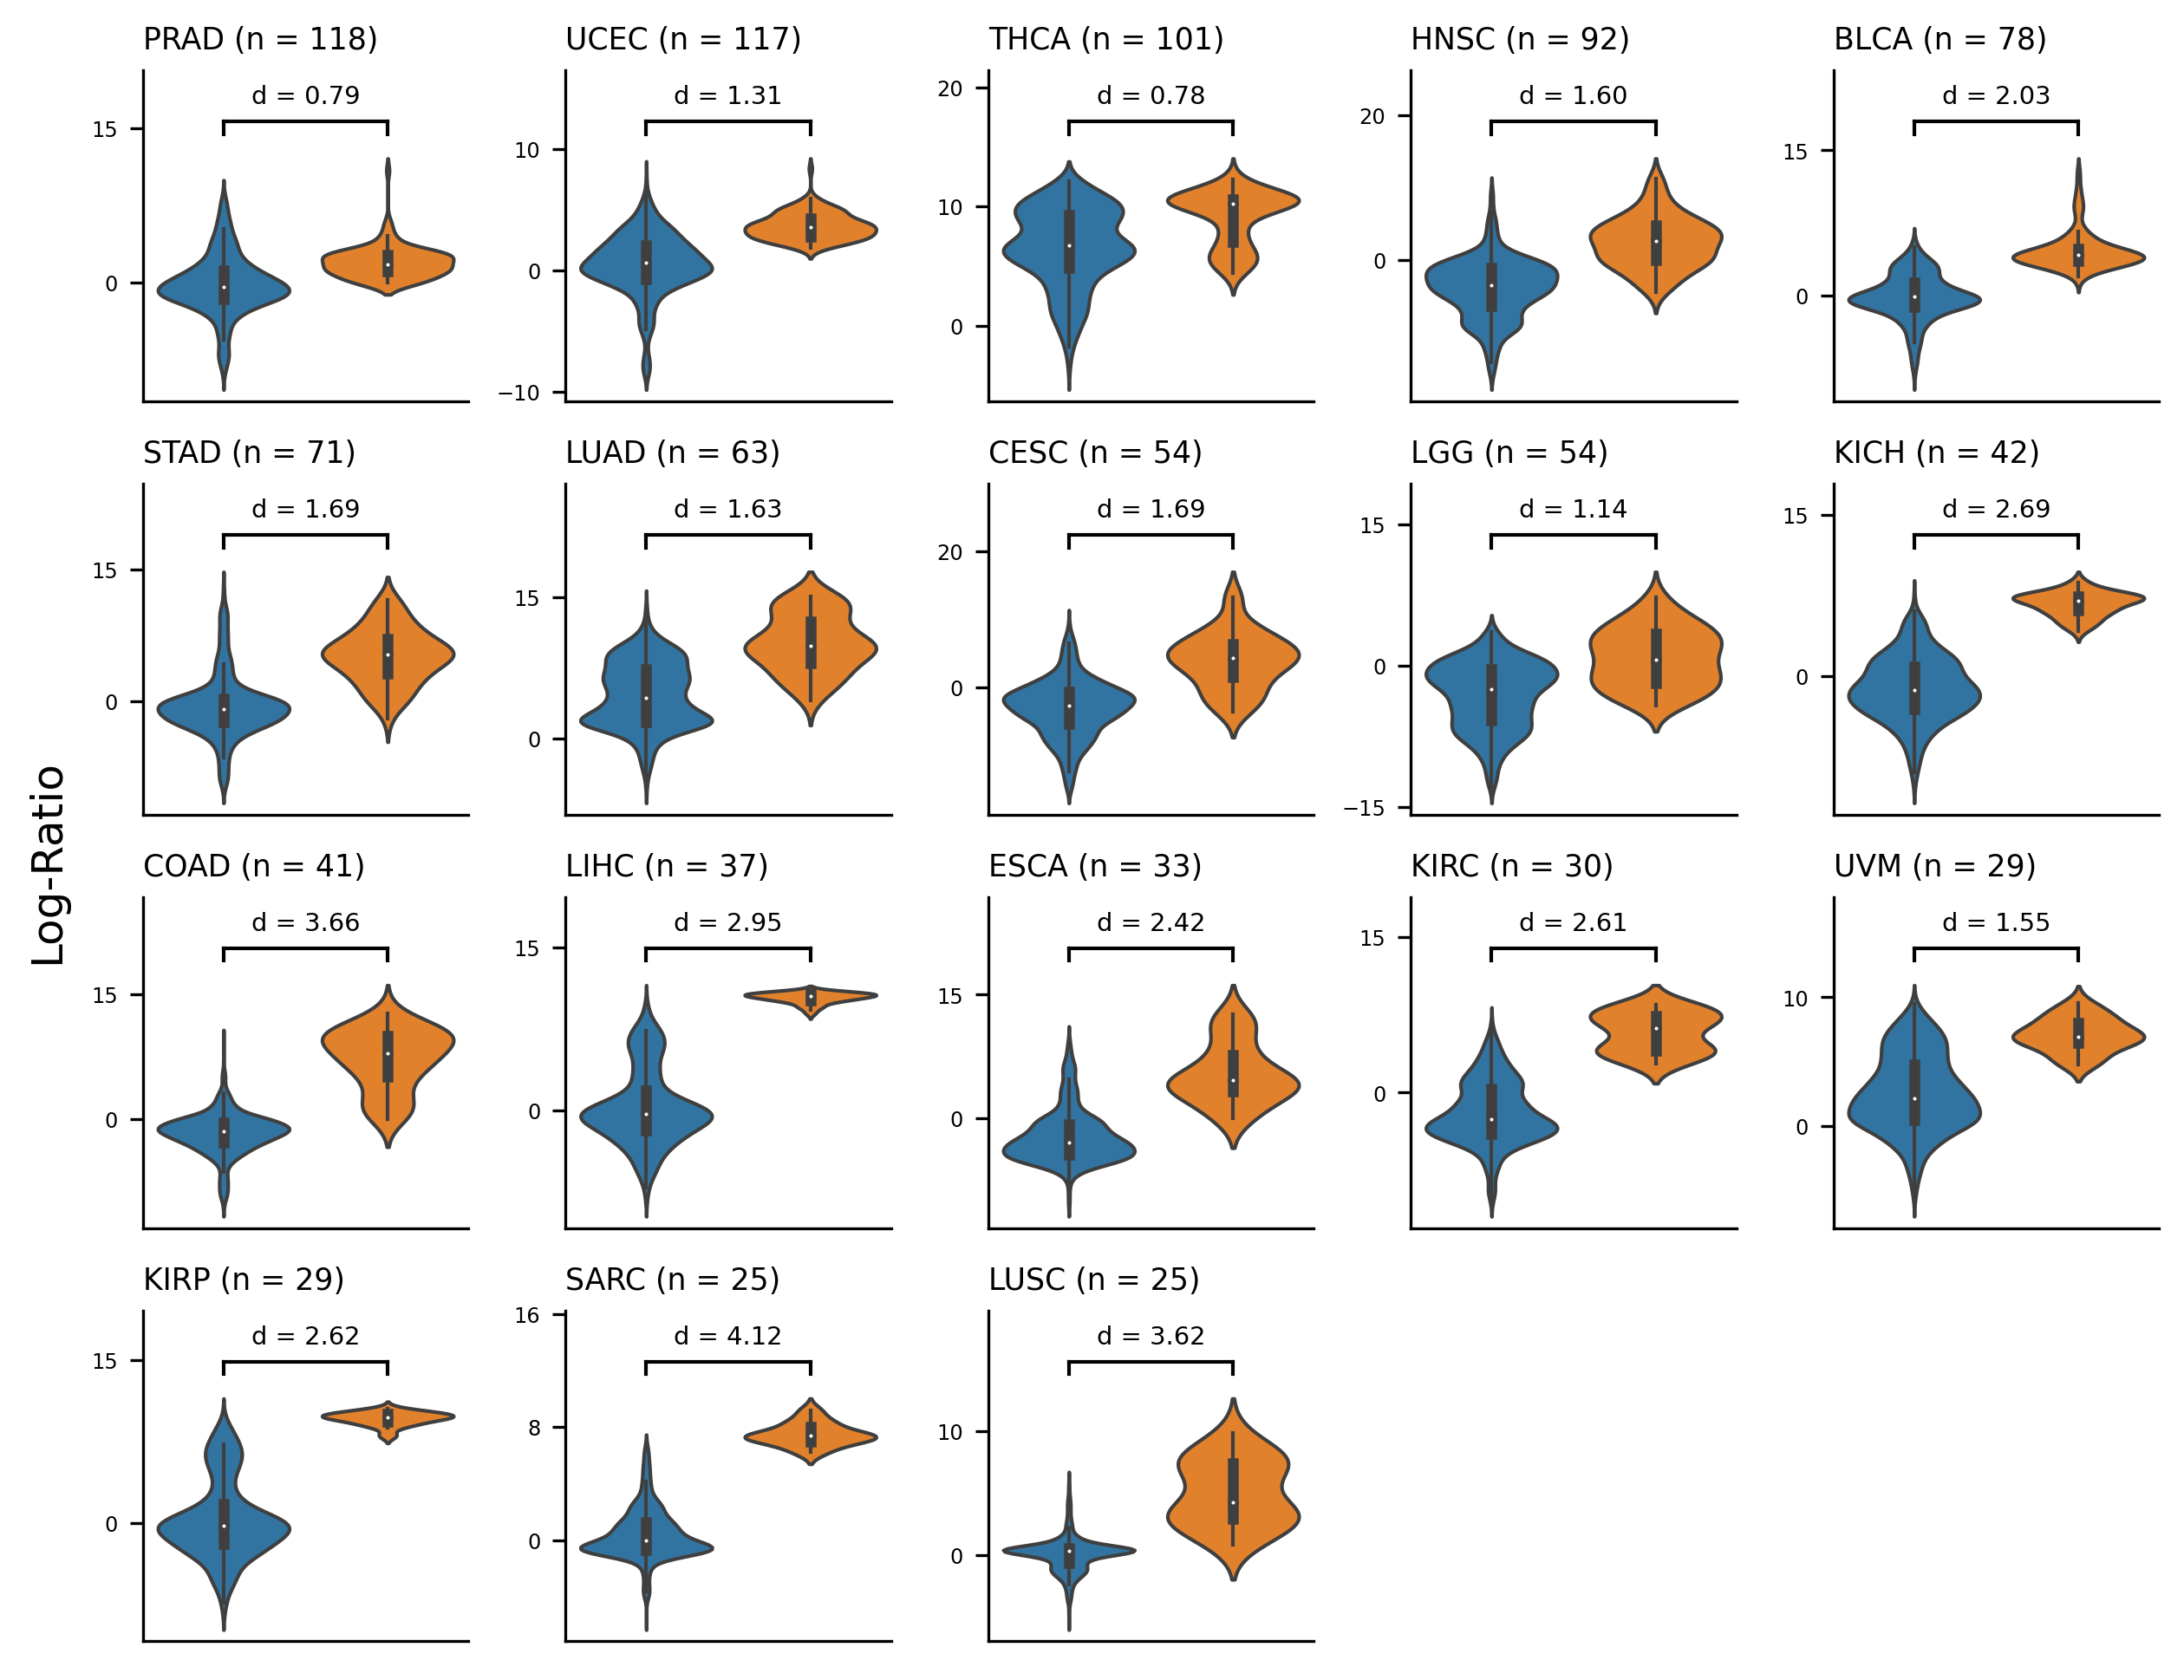

In [28]:
from matplotlib import ticker
fig = plt.figure(figsize=(10, 8))

for i, (invest, _lr) in enumerate(tool_lr_df_dicts["birdman"].items(), start=1):
    ax = fig.add_subplot(4, 5, i)
    _df = pd.concat([_lr, md[["investigation", "data_submitting_center_label"]]], axis=1)
    _df["is_invest"] = _df["investigation"] == invest
    sns.violinplot(
        data=_df,
        x="is_invest",
        y=invest,
        linewidth=1,
        scale="width",
        ax=ax
    )
    ax.xaxis.set_visible(False)
    ax.set_ylabel("")
    ax.tick_params("y", labelsize="xx-small")
    ymin, ymax = ax.get_ylim()
    yrange = ymax - ymin
    ax.set_ylim([ymin, ymax+yrange*0.3])
    
    bot_loc = ymax+yrange*0.05
    top_loc = ymax+yrange*0.1
    ax.plot([0, 1], [top_loc, top_loc], color="k", lw=1)
    ax.plot([0, 0], [bot_loc, top_loc], color="k", lw=1)
    ax.plot([1, 1], [bot_loc, top_loc], color="k", lw=1)
    
    _x = _df.query("is_invest == True")[invest]
    _y = _df.query("is_invest == False")[invest]
    d = calculate_cohens_d(_x, _y)
    ax.text(
        x=0.5,
        y=ymax+yrange*0.15,
        s=f"d = {d:.2f}",
        va="bottom",
        ha="center",
        fontsize="x-small"
    )
    
    ax.yaxis.set_major_locator(ticker.MaxNLocator(3))
    ax.set_title(f"{invest} (n = {len(_x)})", fontsize="small")

plt.subplots_adjust(wspace=0.3, hspace=0.25)
fig.supylabel("Log-Ratio", x=0.08)

plt.show()

In [29]:
model = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=5000,
    class_weight="balanced",
    fit_intercept=True,
    C=1
)

In [30]:
from sklearn.model_selection import StratifiedKFold

new_cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=1)

scorer = make_scorer(balanced_accuracy_score, adjusted=False)
scoring = {"balanced_accuracy": scorer, "f1_weighted": "f1_weighted"}

## Tool Log-Ratios

In [31]:
from collections import defaultdict

tool_perf_dict = defaultdict(dict)

for tool, predictor_df in tool_predictor_dfs.items():
    print(tool)
    for center, _df in predictor_df.groupby("data_submitting_center_label"):
        X = _df[investigations]
        _invests = _df["investigation"].unique()
        _invests = [x for x in _invests if x != "BRCA"]
        X = X[_invests]
        
        y = LabelEncoder().fit_transform(_df["investigation"])
        scores = cross_validate(model, X, y, scoring=scoring, cv=new_cv, n_jobs=-1)
        tool_perf_dict[tool][center] = scores
        
        print(center)
        print(scores["test_f1_weighted"].mean(), scores["test_balanced_accuracy"].mean())
        print("====================================")
    print()

birdman
Baylor College of Medicine
0.8805925304795899 0.8679702461281409
Broad Institute of MIT and Harvard
0.7251175428571444 0.7292703665252686
Harvard Medical School
0.7831770036531489 0.7849993813462193
MD Anderson - Institute for Applied Cancer Science
0.8225232463827101 0.8350210355274486
Washington University School of Medicine
0.9003862514409546 0.9158868092691623

aldex2
Baylor College of Medicine
0.538529083001547 0.5680440417282522
Broad Institute of MIT and Harvard
0.48097347149054687 0.5001443436737555
Harvard Medical School
0.6610090808510902 0.6517354943767988
MD Anderson - Institute for Applied Cancer Science
0.6635463827182009 0.6119979299534807
Washington University School of Medicine
0.672761747491276 0.659613327848622

ancombc
Baylor College of Medicine
0.5382284964301887 0.5711131461131462
Broad Institute of MIT and Harvard
0.4601317896634785 0.46827739072837116
Harvard Medical School
0.6732115057420556 0.6544238712539107
MD Anderson - Institute for Applied Cancer 

## CLR Random Forest

In [32]:
rf_model = RandomForestClassifier(random_state=63, n_estimators=100)
rf_scores = dict()

for center, _df in md.groupby("data_submitting_center_label"):
    idx = _df.index
    
    # Remove feats with all zeros before performing CLR
    X = tbl_df.loc[idx]
    non_zero = tbl_df.loc[idx].any()
    ids_to_keep = non_zero[non_zero].index
    X = X.loc[:, ids_to_keep]
    X = pd.DataFrame(clr(X.values + 1), index=X.index, columns=X.columns)
    
    y = LabelEncoder().fit_transform(_df.loc[idx]["investigation"])
    scores = cross_validate(rf_model, X, y, scoring=scoring, cv=new_cv, n_jobs=-1)
    rf_scores[center] = scores
    print(X.shape)
    print(center)
    print(len(np.unique(y)))
    print(scores["test_f1_weighted"].mean(), scores["test_balanced_accuracy"].mean())
    print("=======================")

(174, 2274)
Baylor College of Medicine
6
0.7466368081994227 0.734796178480389
(159, 2116)
Broad Institute of MIT and Harvard
9
0.5933875058436081 0.5211185292557843
(489, 2280)
Harvard Medical School
11
0.6730111733471905 0.597204563113654
(167, 1948)
MD Anderson - Institute for Applied Cancer Science
7
0.682894535157142 0.5653773957748969
(135, 2265)
Washington University School of Medicine
4
0.716173113150792 0.633195615658851


In [33]:
invest_count_per_center = dict(
    md
    .groupby(["data_submitting_center_label"])
    .apply(lambda x: len(x["investigation"].unique()))
)

In [34]:
tool_acc_dfs = []

for tool, perf_dict in tool_perf_dict.items():
    _df = pd.DataFrame.from_dict(perf_dict)
    _df =  (
        _df
        .apply(pd.Series.explode)
        .reset_index()
        .rename(columns={"index": "metric"})
        .melt(id_vars=["metric"], var_name="center")
        .assign(model=tool_text_styling_dict[tool])
        .query("metric == ['test_balanced_accuracy', 'test_f1_weighted']")
    )
    tool_acc_dfs.append(_df)
    
rf_score_df = pd.DataFrame.from_dict(rf_scores)
rf_score_df = (
    rf_score_df
    .apply(pd.Series.explode)
    .reset_index()
    .rename(columns={"index": "metric"})
    .melt(id_vars=["metric"], var_name="center")
    .assign(model="Random Forest")
    .query("metric == ['test_balanced_accuracy', 'test_f1_weighted']")
)

all_perf_df = pd.concat(tool_acc_dfs + [rf_score_df]).reset_index(drop=True)

all_perf_df["metric"] = all_perf_df["metric"].replace({
    "test_f1_weighted": "Classifier F1 Score",
    "test_balanced_accuracy": "Classifier Accuracy"
})

def add_num_cancer_types(row):
    invest_count = invest_count_per_center[row["center"]]
    return f"{row['center_short']}\n({invest_count} Cancer Types)"

def add_num_samples(center):
    return md.query("data_submitting_center_label == @center").shape[0]

all_perf_df["N"] = all_perf_df["center"].map(add_num_samples)
all_perf_df["center_short"] = all_perf_df["center"].map(centers_short_map)
all_perf_df["center_short"] = all_perf_df.apply(add_num_cancer_types, axis=1)

all_perf_df.head()

metric                      center     value    model    N  \
0  Classifier Accuracy  Baylor College of Medicine  0.925926  BIRDMAn  174   
1  Classifier Accuracy  Baylor College of Medicine  0.911069  BIRDMAn  174   
2  Classifier Accuracy  Baylor College of Medicine  0.891005  BIRDMAn  174   
3  Classifier Accuracy  Baylor College of Medicine  0.909074  BIRDMAn  174   
4  Classifier Accuracy  Baylor College of Medicine  0.842593  BIRDMAn  174   

            center_short  
0  BCM\n(6 Cancer Types)  
1  BCM\n(6 Cancer Types)  
2  BCM\n(6 Cancer Types)  
3  BCM\n(6 Cancer Types)  
4  BCM\n(6 Cancer Types)

In [35]:
from helper import tool_palette, tool_text_styling_dict
tool_palette["Random Forest"] = "lightgray"
order = ["BIRDMAn", "DESeq2", "ALDEx2", "ANCOM-BC", "Songbird", "Random Forest"]

In [36]:
perf_mat = (
    all_perf_df
    .query("metric == 'Classifier Accuracy'")
    .groupby(["center_short", "model"])["value"]
    .apply(lambda x: x.mean())
    .reset_index()
    .pivot(index="center_short", columns="model", values="value")
    .loc[:, order]
)
perf_mat

model                     BIRDMAn    DESeq2    ALDEx2  ANCOM-BC  Songbird  \
center_short                                                                
BCM\n(6 Cancer Types)    0.867970  0.643311  0.568044  0.571113  0.655064   
BI\n(9 Cancer Types)     0.729270  0.507636  0.500144  0.468277  0.439704   
HMS\n(11 Cancer Types)   0.784999  0.618418  0.651735  0.654424  0.632074   
MDA\n(7 Cancer Types)    0.835021  0.702257  0.611998  0.636477  0.653637   
WUSTL\n(4 Cancer Types)  0.915887  0.713355  0.659613  0.547701  0.655939   

model                    Random Forest  
center_short                            
BCM\n(6 Cancer Types)         0.734796  
BI\n(9 Cancer Types)          0.521119  
HMS\n(11 Cancer Types)        0.597205  
MDA\n(7 Cancer Types)         0.565377  
WUSTL\n(4 Cancer Types)       0.633196

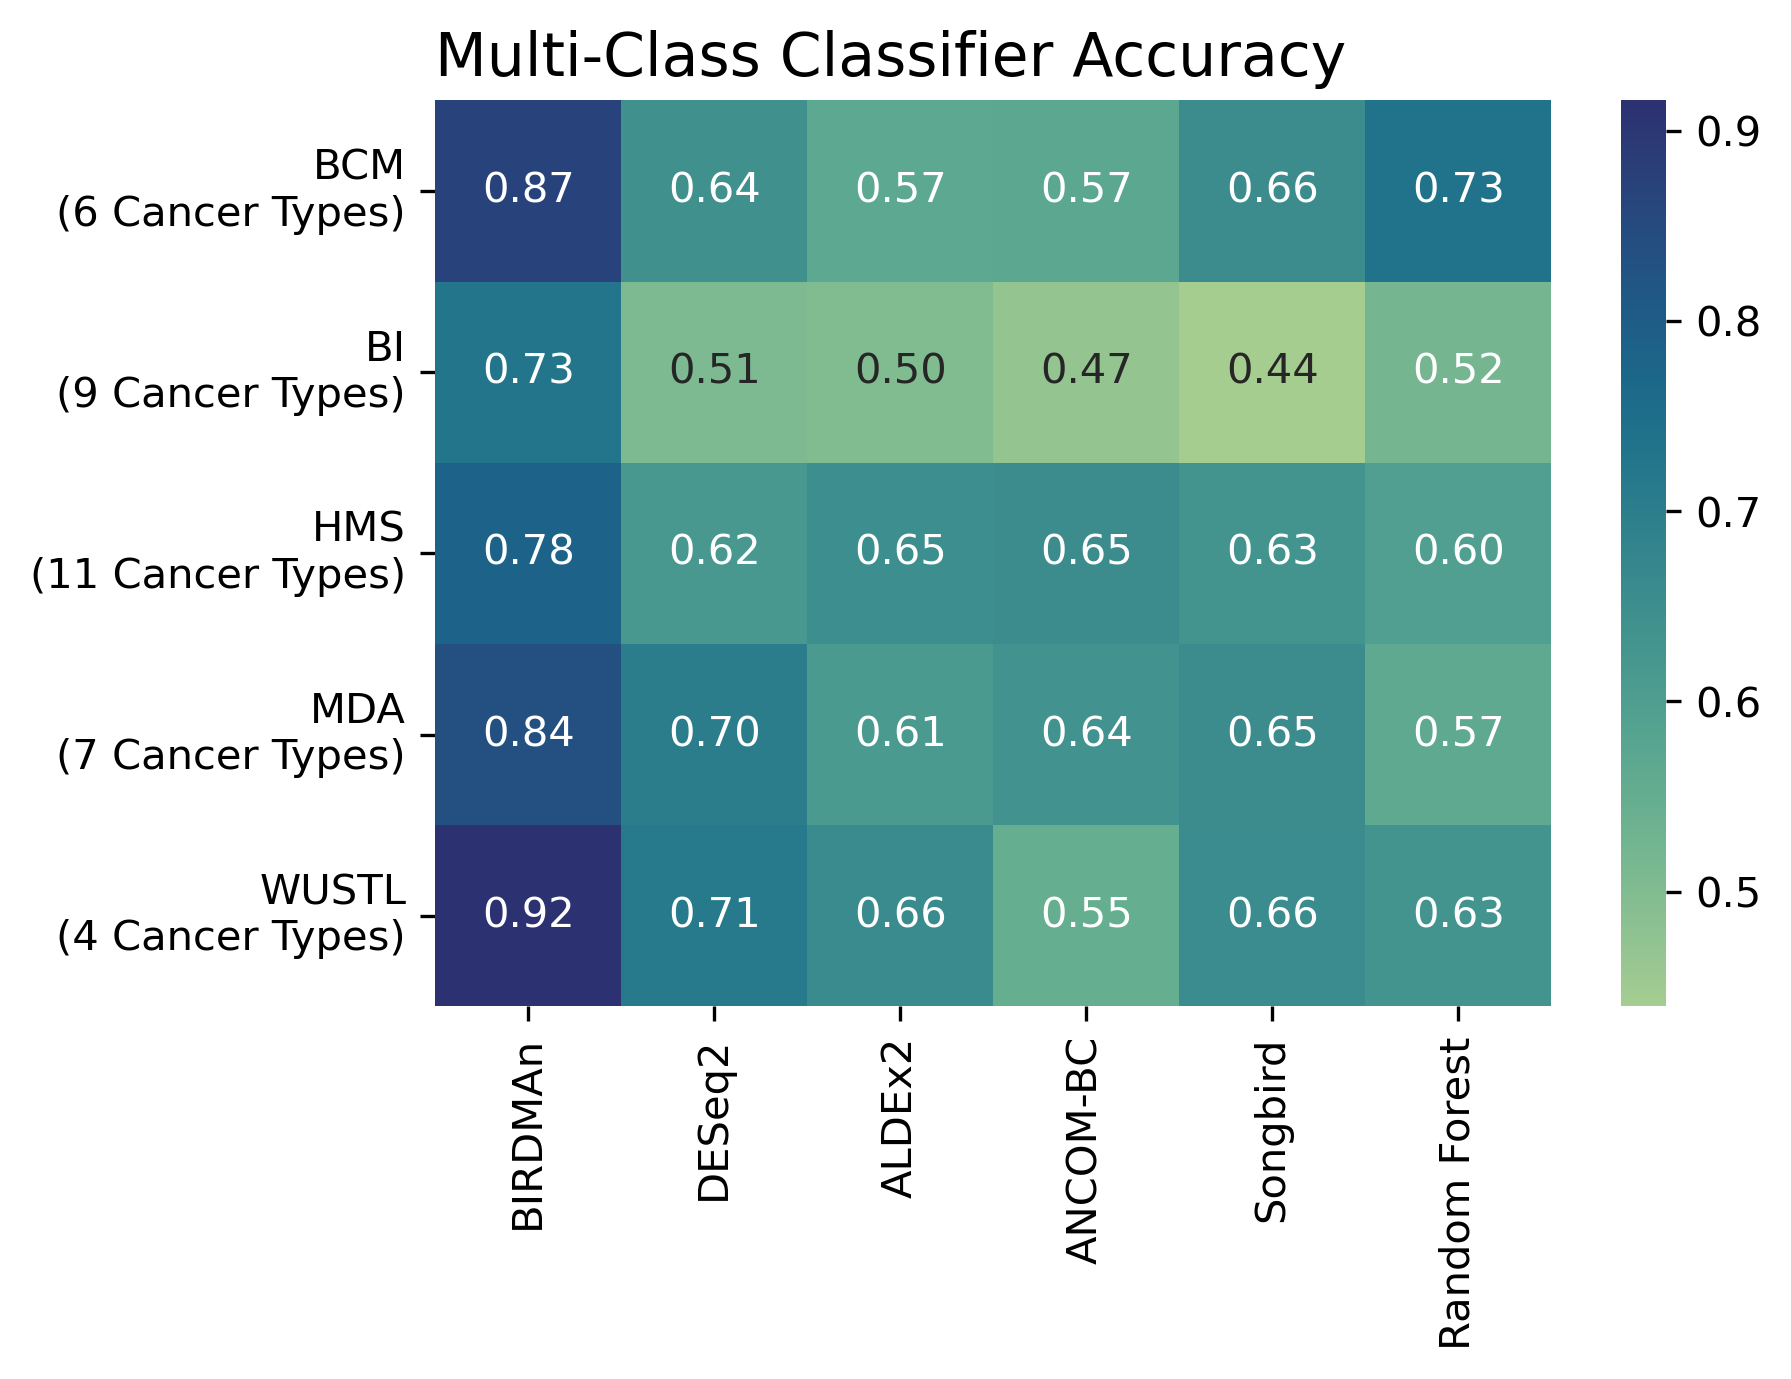

In [70]:
fig, ax = plt.subplots(1, 1)

sns.heatmap(perf_mat, annot=True, cmap="crest", ax=ax, fmt=".2f")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Multi-Class Classifier Accuracy")

plt.savefig("../figures/tcga/per_center_classifier_perf.pdf")
plt.show()

In [38]:
all_predictor_dfs = []

for tool, predictor_df in tool_predictor_dfs.items():
    all_predictor_dfs.append((
        predictor_df
        .assign(tool=tool_text_styling_dict[tool]).reset_index()
        .rename(columns={"index": "sample_name"})
    ))

all_predictor_df = pd.concat(all_predictor_dfs)
all_predictor_df.head()

sample_name      PRAD      UCEC      THCA      HNSC  \
0  S13722.58cfa82de4b0c9d6adf6a502 -0.109788  2.713165  5.509244 -0.928219   
1  S13722.58cfa82de4b0c9d6adf6a4ce  0.291324 -1.589833  4.940867 -2.596956   
2  S13722.58cfa82de4b0c9d6adf6a48a  2.035691  2.540273  5.706810  0.803703   
3  S13722.58cfa82de4b0c9d6adf6a4d4  1.538898  2.389359  7.158655 -0.862960   
4  S13722.58cfa82de4b0c9d6adf6a529  0.349845  2.143520  6.728499  0.042560   

       BLCA      STAD      LUAD      CESC       LGG  ...      LIHC      ESCA  \
0  1.004680 -0.884685  1.704971 -1.426035 -0.010471  ...  5.506296 -3.505002   
1 -2.287861 -3.981400  1.356884 -2.365589  0.644588  ...  0.996890 -5.613277   
2 -1.019004 -0.104236  0.951242  2.969762 -1.288928  ...  2.583958 -4.135823   
3 -2.602133 -1.679330  1.257891  2.430590 -0.930108  ...  2.869593 -5.427337   
4 -2.218791 -1.098612  1.346692 -0.356675 -1.014881  ...  5.597084 -4.288597   

       KIRC       UVM      KIRP      SARC      LUSC  investigation  \
0  2.077124 -0.132073  4.866335  0.639658 -0.804229           UCEC   
1  1.981369  1.901739  0.397395 -3.521764  0.600785           BRCA   
2  0.201762  2.318096  2.809095  0.449491  0.133576           UCEC   
3 -2.136996  3.099019  2.766671 -0.866716  0.745927           UCEC   
4 -0.136012  1.323515  5.476464  0.557192 -0.131028           UCEC   

               data_submitting_center_label     tool  
0  Washington University School of Medicine  BIRDMAn  
1  Washington University School of Medicine  BIRDMAn  
2  Washington University School of Medicine  BIRDMAn  
3  Washington University School of Medicine  BIRDMAn  
4  Washington University School of Medicine  BIRDMAn  

[5 rows x 22 columns]

In [39]:
results_dfs = []
for i, center in enumerate(centers, start=1):    
    results_dict = defaultdict(dict)
    _df_center = all_predictor_df[all_predictor_df["data_submitting_center_label"] == center]
    for invest in _df_center["investigation"].unique():
        if invest == "BRCA":
            continue
            
        for tool, _df in _df_center.groupby("tool"):
            x = _df[_df["investigation"] == invest][invest]
            y = _df[_df["investigation"] != invest][invest]

            t, p = ss.ttest_ind(x, y, alternative="greater")
            results_dict[tool][invest] = -np.log10(p)
    
    results = (
        pd.DataFrame.from_dict(results_dict)
        .T
        .reset_index()
        .rename(columns={"index": "tool"})
        .melt(id_vars="tool", value_name="neg_log10_p", var_name="investigation")
        .assign(center=center)
    )
    results_dfs.append(results)
    
all_result_df = pd.concat(results_dfs)
all_result_df["center"] = all_result_df["center"].map(centers_short_map)

In [40]:
all_result_df.head()

tool investigation  neg_log10_p center
0    ALDEx2          UCEC     0.346250  WUSTL
1  ANCOM-BC          UCEC     0.299089  WUSTL
2   BIRDMAn          UCEC     5.679865  WUSTL
3    DESeq2          UCEC     5.352959  WUSTL
4  Songbird          UCEC     0.273750  WUSTL

In [41]:
all_result_df.groupby("tool")["neg_log10_p"].mean()

tool
ALDEx2       7.568039
ANCOM-BC     6.257075
BIRDMAn     16.948726
DESeq2       9.177195
Songbird     8.940138
Name: neg_log10_p, dtype: float64

In [42]:
all_result_df.groupby(["center", "tool"])["neg_log10_p"].mean()

center  tool    
BCM     ALDEx2       8.918164
        ANCOM-BC     9.291778
        BIRDMAn     23.069273
        DESeq2       7.286908
        Songbird     9.821725
BI      ALDEx2       4.186343
        ANCOM-BC     5.052154
        BIRDMAn      9.096949
        DESeq2       5.659234
        Songbird     3.246121
HMS     ALDEx2      11.247309
        ANCOM-BC     9.060895
        BIRDMAn     18.941490
        DESeq2      13.299561
        Songbird    17.288870
MDA     ALDEx2       5.519744
        ANCOM-BC     2.421095
        BIRDMAn     14.822708
        DESeq2       8.127931
        Songbird     4.896812
WUSTL   ALDEx2       6.845237
        ANCOM-BC     2.128324
        BIRDMAn     25.872453
        DESeq2      11.868958
        Songbird     4.516558
Name: neg_log10_p, dtype: float64

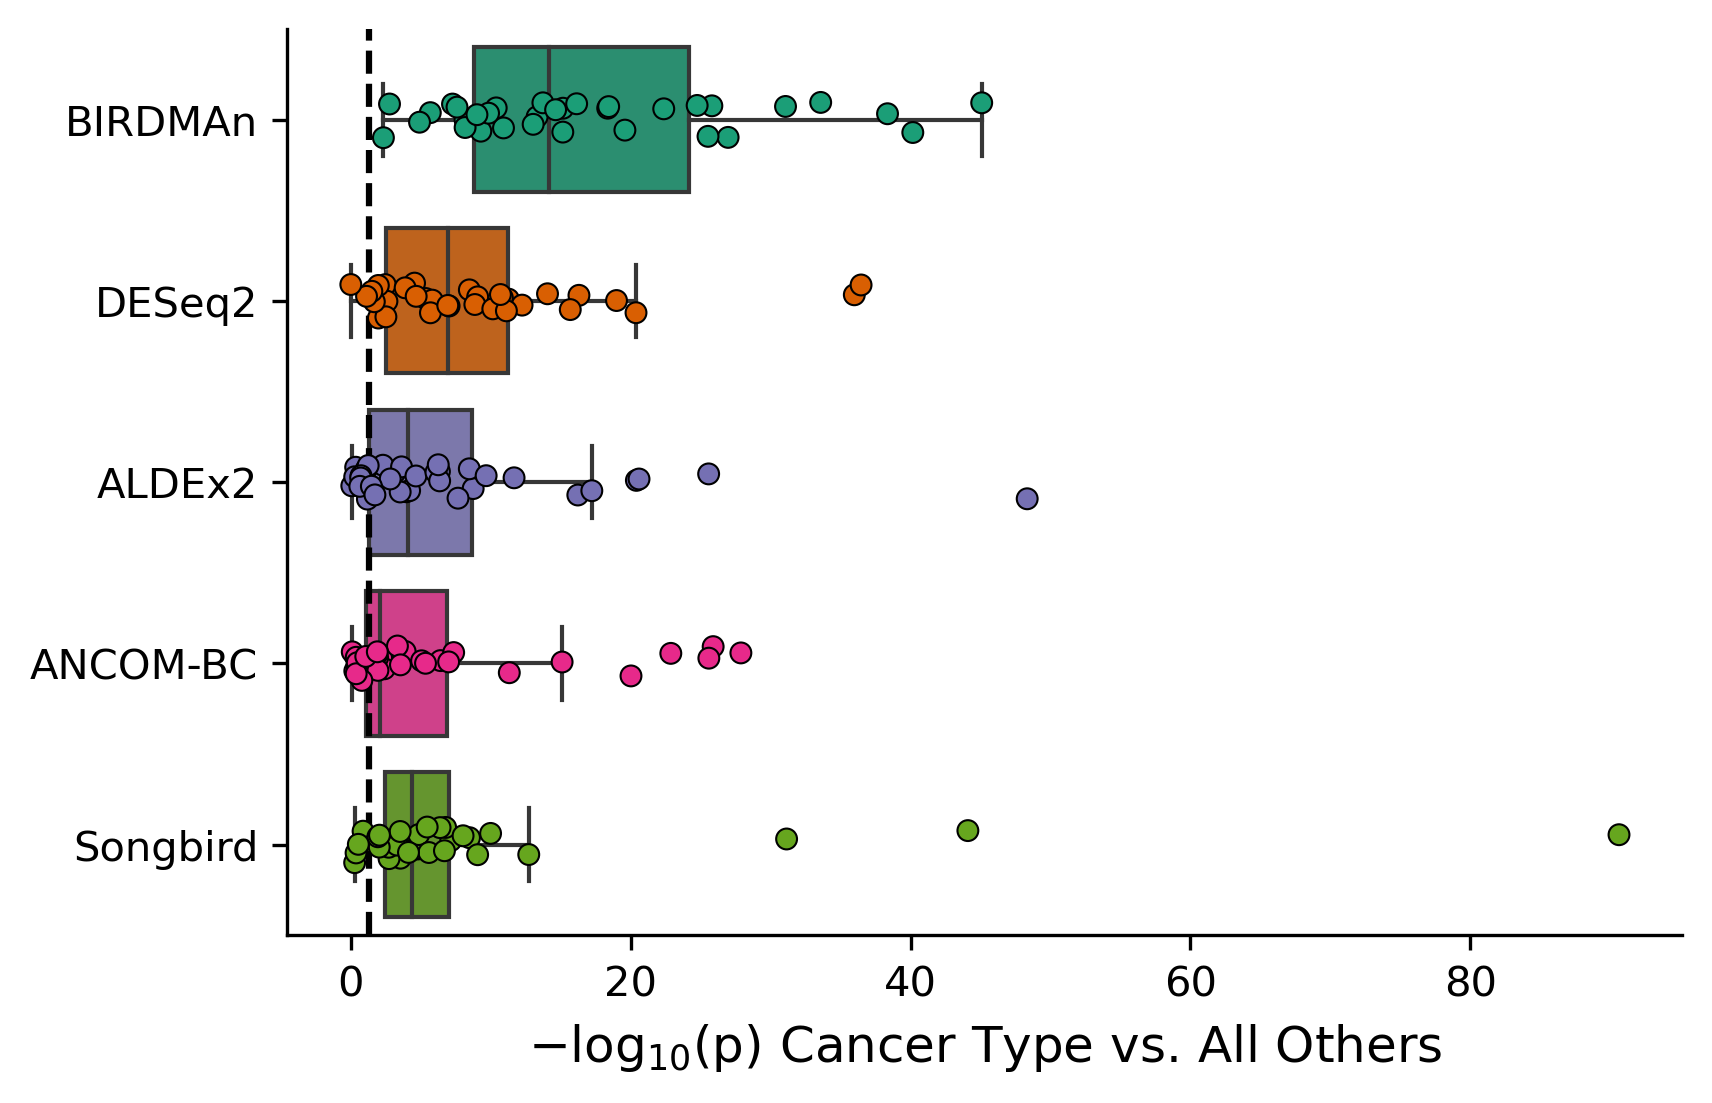

In [43]:
fig, ax = plt.subplots(1, 1)

sns.boxplot(
    data=all_result_df,
    x="neg_log10_p",
    y="tool",
    order=order[:-1],
    palette=tool_palette,
    linewidth=1,
    showfliers=False,
    ax=ax
)

sns.stripplot(
    data=all_result_df,
    x="neg_log10_p",
    y="tool",
    order=order[:-1],
    edgecolor="black",
    linewidth=0.5,
    palette=tool_palette,
    ax=ax
)

ax.axvline(-np.log10(0.05), ls="--", color="k")
ax.set_ylabel("")
ax.set_xlabel(r"$-\log_{10}\left(\mathrm{p}\right)$ Cancer Type vs. All Others")

plt.savefig("../figures/tcga/neg_log10_p_by_tool.pdf")
plt.show()

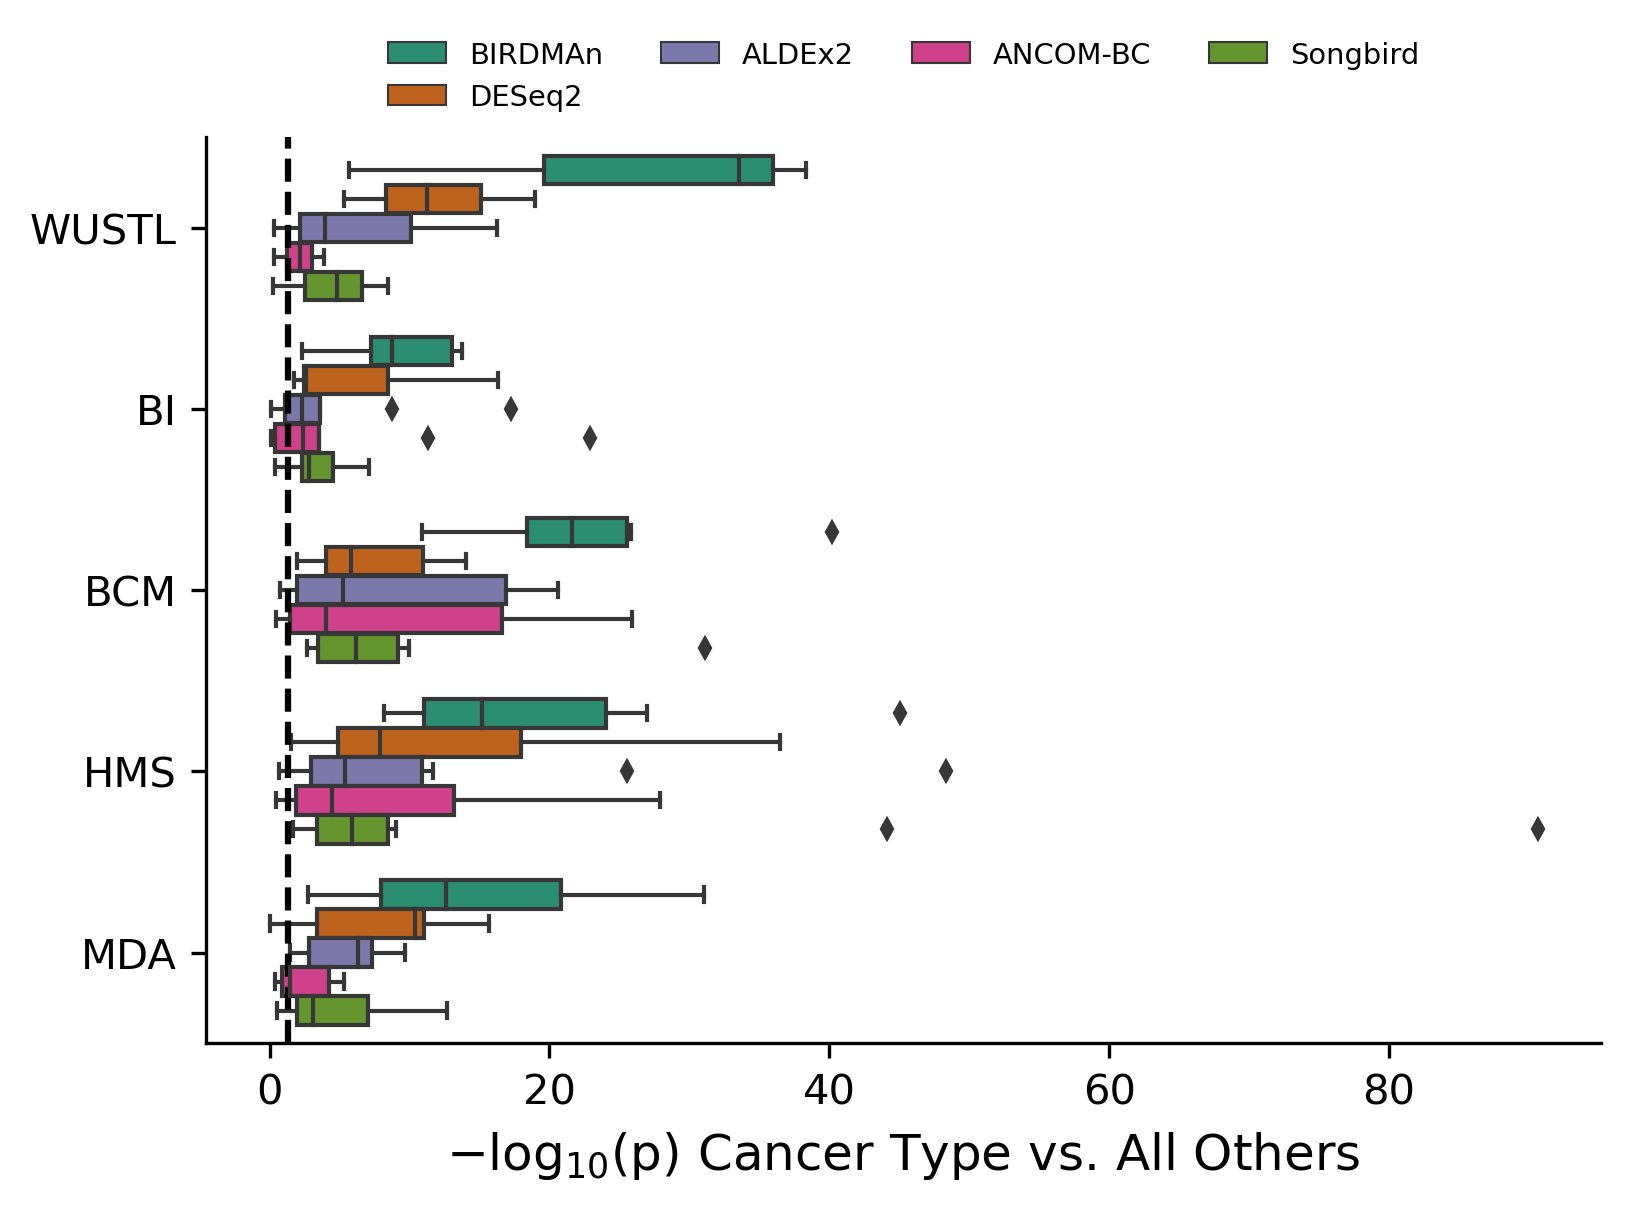

In [44]:
fig, ax = plt.subplots(1, 1)
sns.boxplot(
    data=all_result_df,
    y="center",
    x="neg_log10_p",
    hue="tool",
    palette=tool_palette,
    linewidth=1,
    hue_order=order[:-1],
    flierprops={"markersize": 3},
    ax=ax
)
ax.axvline(-np.log10(0.05), ls="--", color="k")

ax.set_ylabel("")
ax.set_xlabel(r"$-\log_{10}\left(\mathrm{p}\right)$ Cancer Type vs. All Others")

ax.legend(
    loc="lower center",
    bbox_to_anchor=[0.5, 1],
    ncol=4,
    frameon=False,
)

plt.savefig("../figures/tcga/neg_log10_p_by_center_tool.pdf")
plt.show()

# Leave one center out

In [45]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc

log_reg = LogisticRegression(
    penalty="none",
    solver="lbfgs",
    class_weight="balanced",
    max_iter=5000
)

def leave_one_center_out(predictor_df, investigation):
    all_centers = md.query("investigation == @investigation")["data_submitting_center_label"].unique()
    
    X = predictor_df[predictor_df["data_submitting_center_label"].isin(all_centers)]
    y = (X["investigation"] == investigation).astype(int)
    X = X.drop(columns=["investigation", "data_submitting_center_label"])
    X = X[[investigation]]
    
    perf_dict = dict()

    for group in all_centers:
        train_idx = predictor_df[
            (predictor_df["data_submitting_center_label"].isin(all_centers)) &
            (predictor_df["data_submitting_center_label"] != group)
        ].index
        test_idx = md[md["data_submitting_center_label"] == group].index

        X_train = X.loc[train_idx]
        y_train = y.loc[train_idx]

        X_test = X.loc[test_idx]
        y_test = y.loc[test_idx]

        log_reg.fit(X_train, y_train)
        y_proba = log_reg.predict_proba(X_test)
        y_pred = log_reg.predict(X_test)

        fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
        precision, recall, _ = precision_recall_curve(y_test, y_proba[:, 1])
        
        auc_roc = roc_auc_score(y_test, y_proba[:, 1])
        auc_pr = auc(recall, precision)

        perf_dict[group] = {
            "fpr": fpr,
            "tpr": tpr,
            "auc_roc": auc_roc,
            "precision": precision,
            "recall": recall,
            "auc_prc": auc_pr
        }
                
    return perf_dict

In [46]:
def leave_one_center_out_rf(investigation):
    invest_md = md.query("investigation == @investigation")
    all_centers = invest_md["data_submitting_center_label"].unique()
    idx = invest_md.index
    
    X = pd.DataFrame(clr(tbl_df.values + 1), index=tbl_df.index, columns=tbl_df.columns)
    y = (md["investigation"] == investigation).astype(int)
    
    perf_dict = dict()

    for group in all_centers:
        train_idx = md[
            (md["data_submitting_center_label"].isin(all_centers)) &
            (md["data_submitting_center_label"] != group)
        ].index
        test_idx = md[md["data_submitting_center_label"] == group].index

        X_train = X.loc[train_idx]
        y_train = y.loc[train_idx]

        X_test = X.loc[test_idx]
        y_test = y.loc[test_idx]
        
        rf_model.fit(X_train, y_train)
        y_proba = rf_model.predict_proba(X_test)
        y_pred = rf_model.predict(X_test)

        fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
        precision, recall, _ = precision_recall_curve(y_test, y_proba[:, 1])
        
        auc_roc = roc_auc_score(y_test, y_proba[:, 1])
        auc_pr = auc(recall, precision)

        perf_dict[group] = {
            "fpr": fpr,
            "tpr": tpr,
            "auc_roc": auc_roc,
            "precision": precision,
            "recall": recall,
            "auc_prc": auc_pr
        }
                
    return perf_dict

In [47]:
from collections import defaultdict

loo_invests = ["HNSC", "BLCA", "THCA", "CESC"]
loo_perf_dict = defaultdict(dict)

for invest in loo_invests:
    for tool, _df in tool_predictor_dfs.items():
        loo_perf_dict[tool][invest] = leave_one_center_out(_df, invest)
    loo_perf_dict["Random Forest"][invest] = leave_one_center_out_rf(invest)

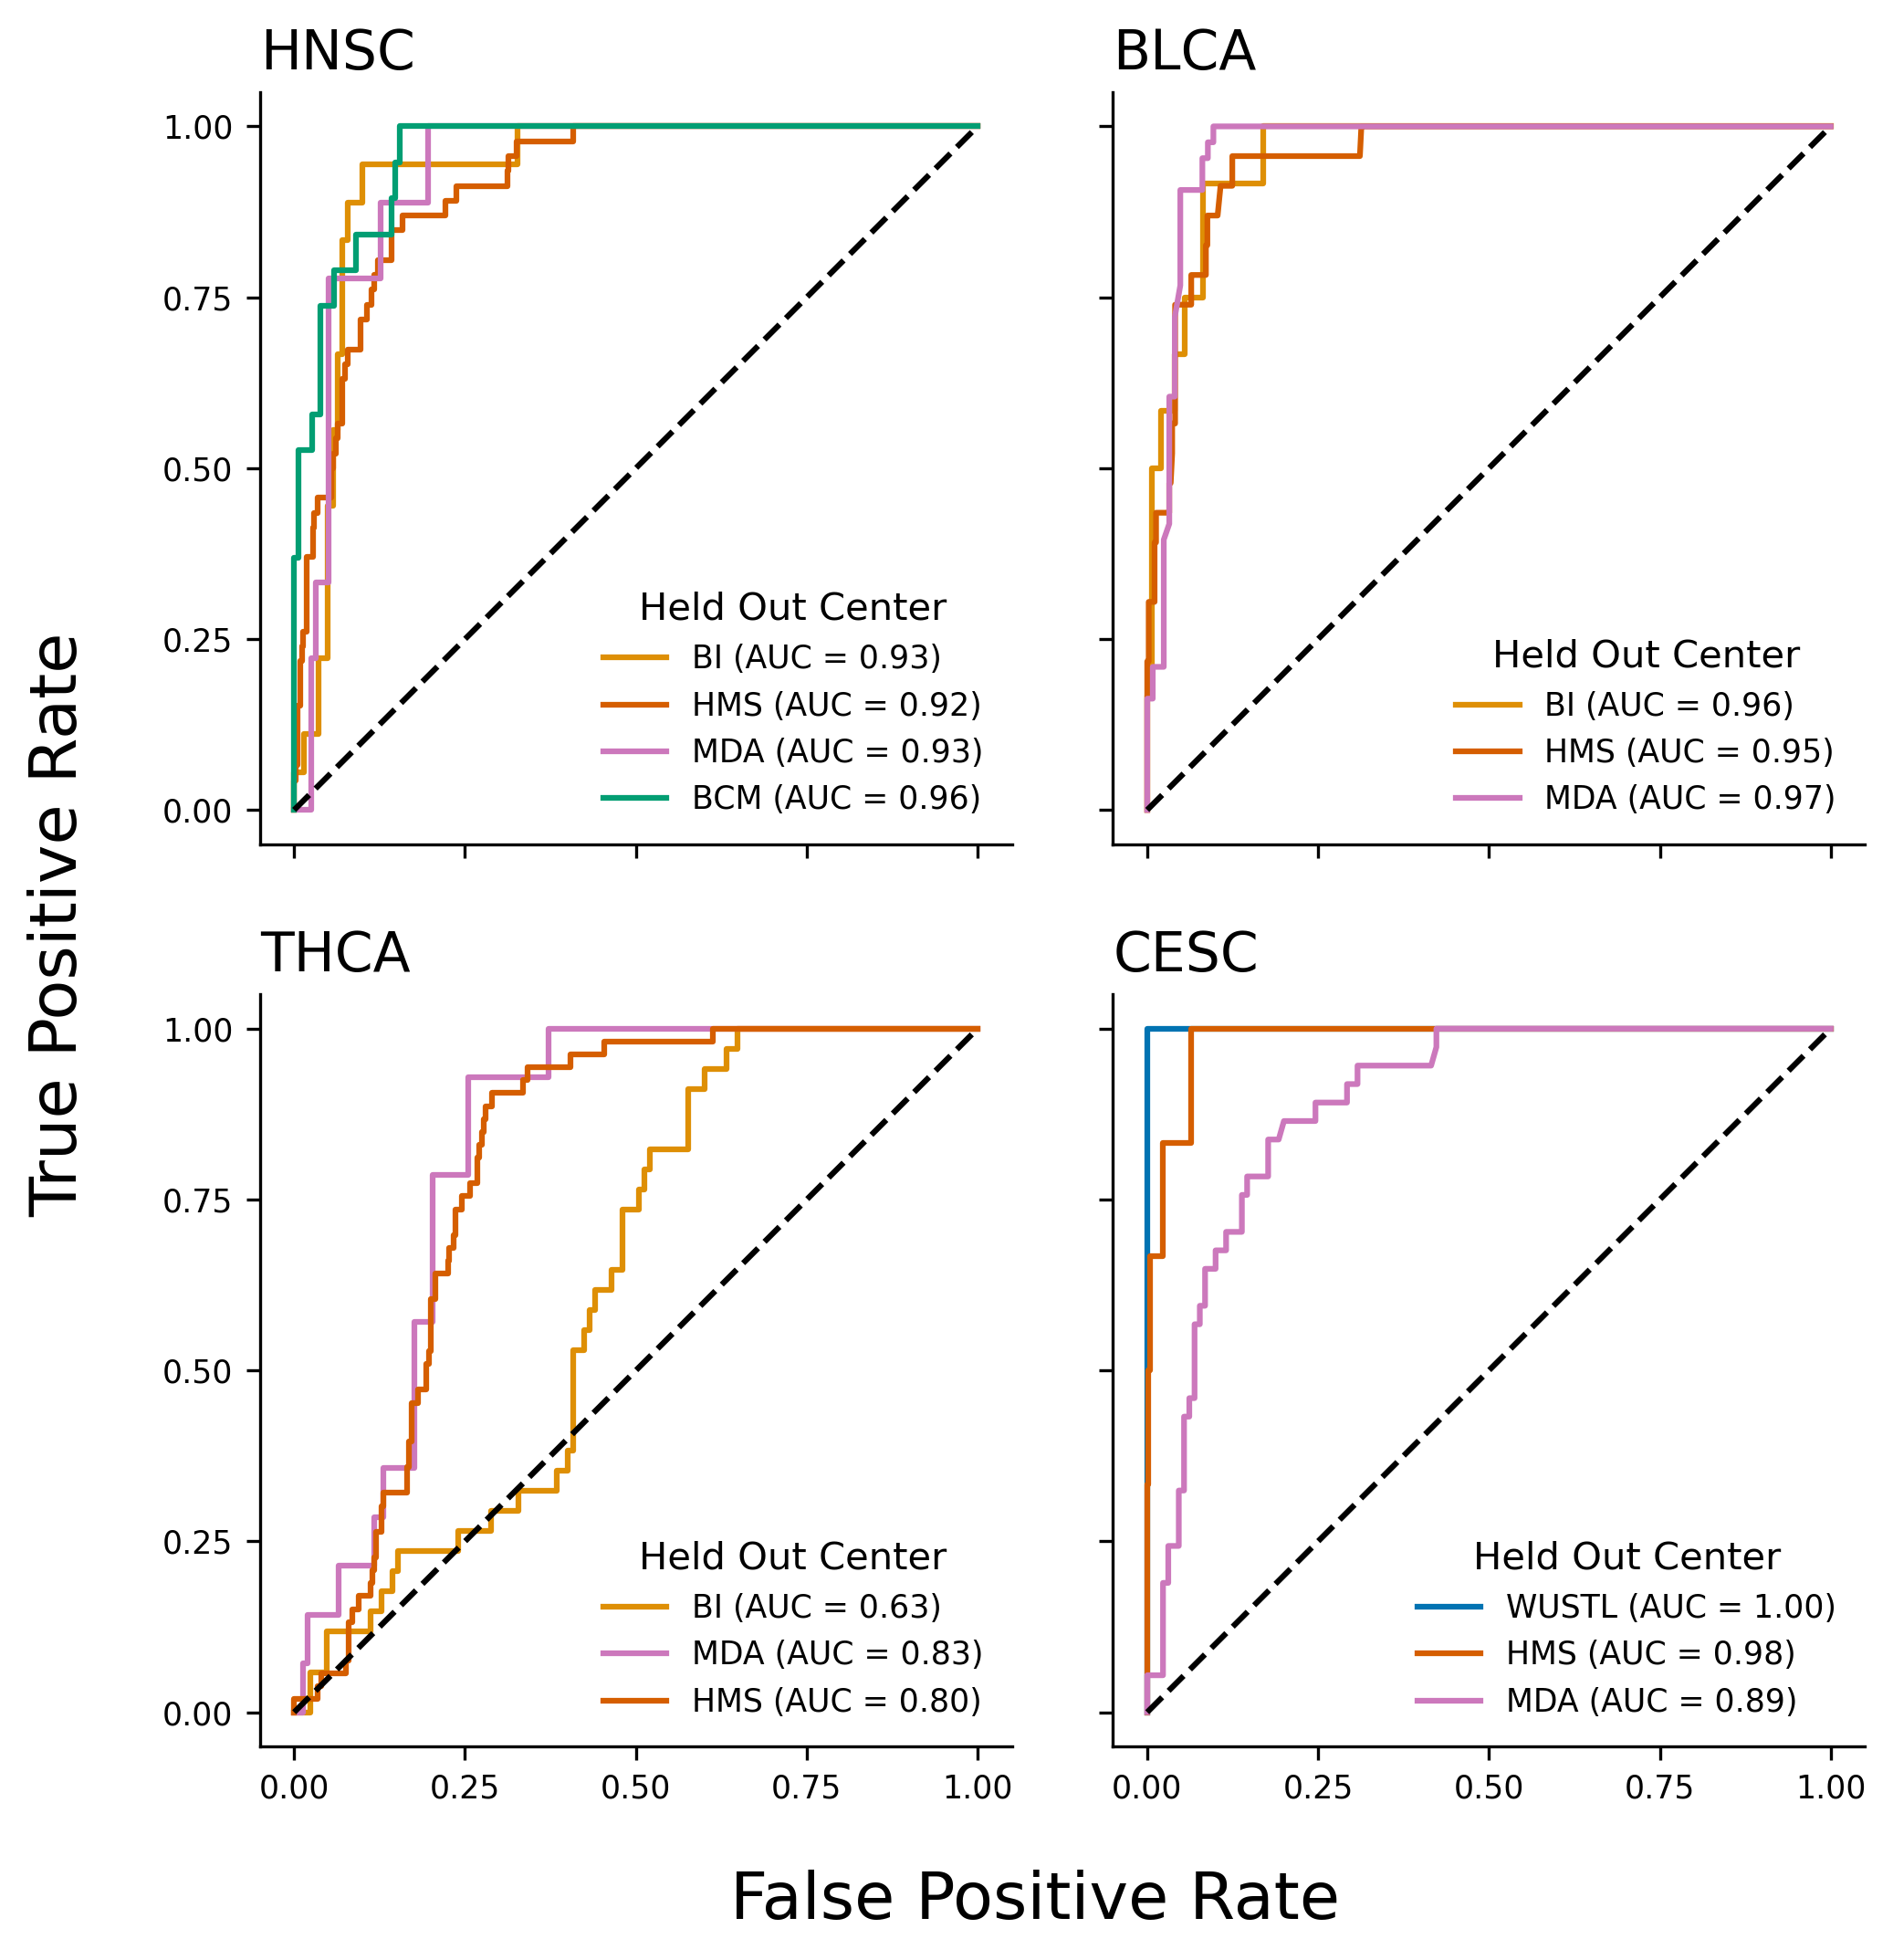

In [48]:
fig, axs = plt.subplots(2, 2, sharey=True, figsize=(8, 8), sharex=True)
plt.subplots_adjust(wspace=0.01)

for ax, invest in zip(axs.flatten(), loo_invests):
    perf_dict = loo_perf_dict["birdman"][invest]
    aucs = [v["auc_roc"] for k, v in perf_dict.items()]
    
    for group, group_dict in perf_dict.items():
        label = f"{centers_short_map[group]} (AUC = {group_dict['auc_roc']:.2f})"
        ax.plot(
            group_dict["fpr"],
            group_dict["tpr"],
            label=label,
            color=center_pal[group]
        )

    ax.legend(title="Held Out Center", frameon=False, fontsize="small")
    ax.plot([0, 1], [0, 1], ls="--", color="k")
    ax.set_aspect("equal")
    ax.set_title(invest)
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
    
    ax.tick_params("both", labelsize="small")

fig.supxlabel("False Positive Rate", y=0.04, fontsize="xx-large")
fig.supylabel("True Positive Rate", x=0.04, fontsize="xx-large")

plt.savefig("../figures/tcga/leave_one_center_out_birdman.pdf")
plt.show()

In [49]:
auc_roc_dict = defaultdict(dict)

for tool, _tool_dict in loo_perf_dict.items():
    for invest, _invest_dict in _tool_dict.items():
        auc_roc_dict[tool][invest] = [x["auc_roc"] for x in _invest_dict.values()]

In [50]:
auc_roc_df = (
    pd.DataFrame.from_dict(auc_roc_dict)
    .apply(lambda x: x.explode())
    .reset_index()
    .melt(id_vars=["index"])
    .rename(columns={"index": "Cancer Type",
                     "variable": "Tool",
                     "value": "AUROC"})
    .assign(Tool=lambda x: x["Tool"].replace(tool_text_styling_dict))
)
auc_roc_df

Cancer Type           Tool     AUROC
0         HNSC        BIRDMAn  0.931048
1         HNSC        BIRDMAn  0.916429
2         HNSC        BIRDMAn  0.932489
3         HNSC        BIRDMAn  0.960272
4         BLCA        BIRDMAn  0.960317
..         ...            ...       ...
73        THCA  Random Forest  0.809757
74        THCA  Random Forest  0.807859
75        CESC  Random Forest  0.730205
76        CESC  Random Forest  0.846273
77        CESC  Random Forest  0.863825

[78 rows x 3 columns]

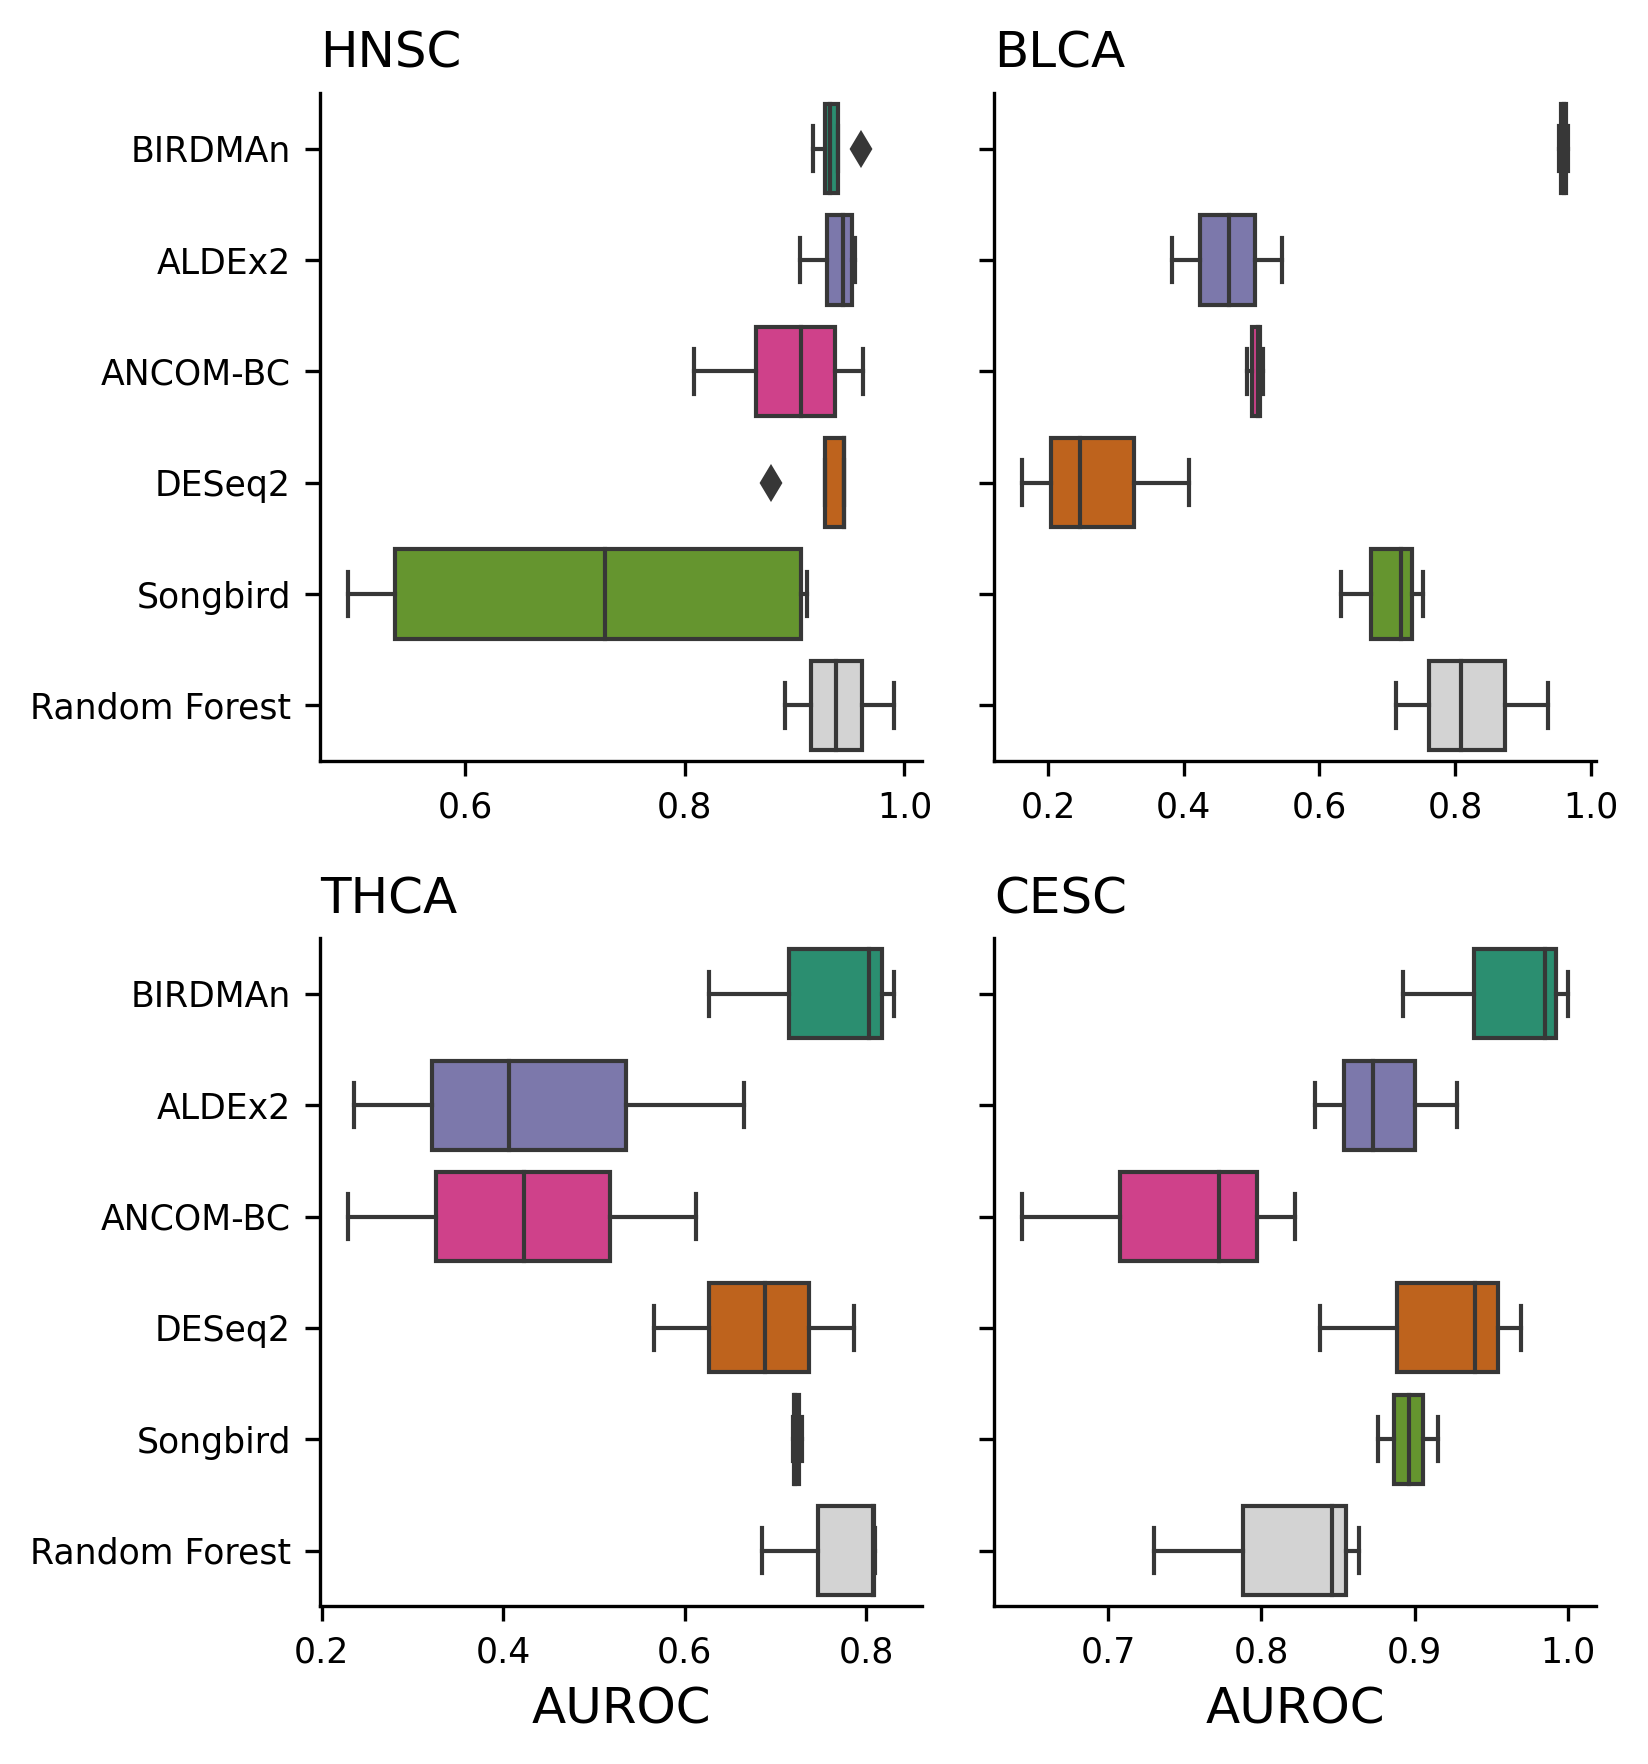

In [51]:
g = sns.catplot(
    data=auc_roc_df,
    x="AUROC",
    y="Tool",
    col="Cancer Type",
    kind="box",
    height=3,
    #aspect=.3,
    col_wrap=2,
    sharex=False,
    palette=tool_palette,
    linewidth=1
)
g.set_titles("{col_name}", size="large")
g.set_axis_labels("AUROC", "")

for ax in g.axes:
    ax.tick_params("both", labelsize="small")

plt.savefig("../figures/tcga/leave_one_center_out_all.pdf")
plt.show()

# Lung vs. GI

In [52]:
tax = pd.read_table("../data/tcga/taxonomy_table_rep200.tsv", sep="\t", index_col=0).loc[summ_diff_cent.index]
tax.head()

Domain             Phylum                   Class  \
Feature                                                              
G000143845  k__Bacteria  p__Actinobacteria       c__Coriobacteriia   
G009740265  k__Bacteria  p__Proteobacteria  c__Gammaproteobacteria   
G002370355  k__Bacteria      p__Firmicutes              c__Bacilli   
G001042675  k__Bacteria  p__Actinobacteria       c__Actinobacteria   
G000284255  k__Bacteria  p__Proteobacteria   c__Betaproteobacteria   

                           Order                 Family             Genus  \
Feature                                                                     
G000143845   o__Coriobacteriales        f__Atopobiaceae      g__Olsenella   
G009740265   o__Enterobacterales      f__Morganellaceae        g__Proteus   
G002370355    o__Lactobacillales    f__Lactobacillaceae  g__Lactobacillus   
G001042675  o__Bifidobacteriales  f__Bifidobacteriaceae  g__Parascardovia   
G000284255    o__Burkholderiales                    f__     g__Rubrivivax   

                                 Species  
Feature                                   
G000143845              s__Olsenella uli  
G009740265           s__Proteus cibarius  
G002370355        s__Lactobacillus sakei  
G001042675  s__Parascardovia denticolens  
G000284255     s__Rubrivivax gelatinosus

In [53]:
lung_cancers = ["LUSC", "LUAD"]
gi_cancers = ["ESCA", "COAD", "HNSC", "STAD"]

draw_path = pathlib.Path("../results/tcga/species/draws/")
draw_files = draw_path.glob("*.tsv")

draw_dfs = []

for f in draw_files:
    _df = pd.read_table(f, index_col=0)[lung_cancers + gi_cancers]
    _df["feature"] = f.stem
    draw_dfs.append(_df)

draw_df = pd.concat(draw_dfs)

In [54]:
for col, vals in draw_df.iteritems():
    if col == "feature":
        continue
    draw_df[col] = vals - vals.mean()

In [55]:
draw_df["lung_minus_gi"] = draw_df[lung_cancers].mean(axis=1) - draw_df[gi_cancers].mean(axis=1)

In [56]:
lung_minus_gi = (
    draw_df[["feature", "lung_minus_gi"]]
    .groupby("feature")
    .quantile([0.05, 0.5, 0.95])
    .reset_index()
    .pivot(index="feature", columns="level_1", values="lung_minus_gi")
    .join(tax)
)
lung_minus_gi = lung_minus_gi.sort_values(by=0.5)
lung_minus_gi.head()

0.05       0.5      0.95       Domain             Phylum  \
feature                                                                     
G900155655 -10.372470 -6.452867 -2.780322  k__Bacteria   p__Bacteroidetes   
G002998535 -10.502287 -6.390292 -2.503020  k__Bacteria   p__Bacteroidetes   
G001298465 -10.404832 -6.331617 -2.518113  k__Bacteria  p__Proteobacteria   
G000613445 -10.136956 -6.232977 -2.538437  k__Bacteria   p__Bacteroidetes   
G001717505 -10.473624 -6.222179 -2.283257  k__Bacteria      p__Firmicutes   

                               Class                 Order  \
feature                                                      
G900155655            c__Bacteroidia      o__Bacteroidales   
G002998535            c__Bacteroidia      o__Bacteroidales   
G001298465  c__Epsilonproteobacteria  o__Campylobacterales   
G000613445            c__Bacteroidia      o__Bacteroidales   
G001717505          c__Negativicutes     o__Veillonellales   

                           Family             Genus  \
feature                                               
G900155655      f__Prevotellaceae     g__Prevotella   
G002998535      f__Bacteroidaceae    g__Bacteroides   
G001298465  f__Campylobacteraceae  g__Campylobacter   
G000613445      f__Prevotellaceae     g__Prevotella   
G001717505     f__Veillonellaceae      g__Dialister   

                                   Species  
feature                                     
G900155655            s__Prevotella ihumii  
G002998535  s__Bacteroides heparinolyticus  
G001298465       s__Campylobacter concisus  
G000613445            s__Prevotella shahii  
G001717505       s__Dialister pneumosintes

In [57]:
gi_genera = [
    "g__Fusobacterium",
    "g__Prevotella",
    "g__Coprococcus"
]
lung_genera = [
    "g__Staphylococcus",
    "g__Pseudomonas",
    "g__Sphingobacterium"
]

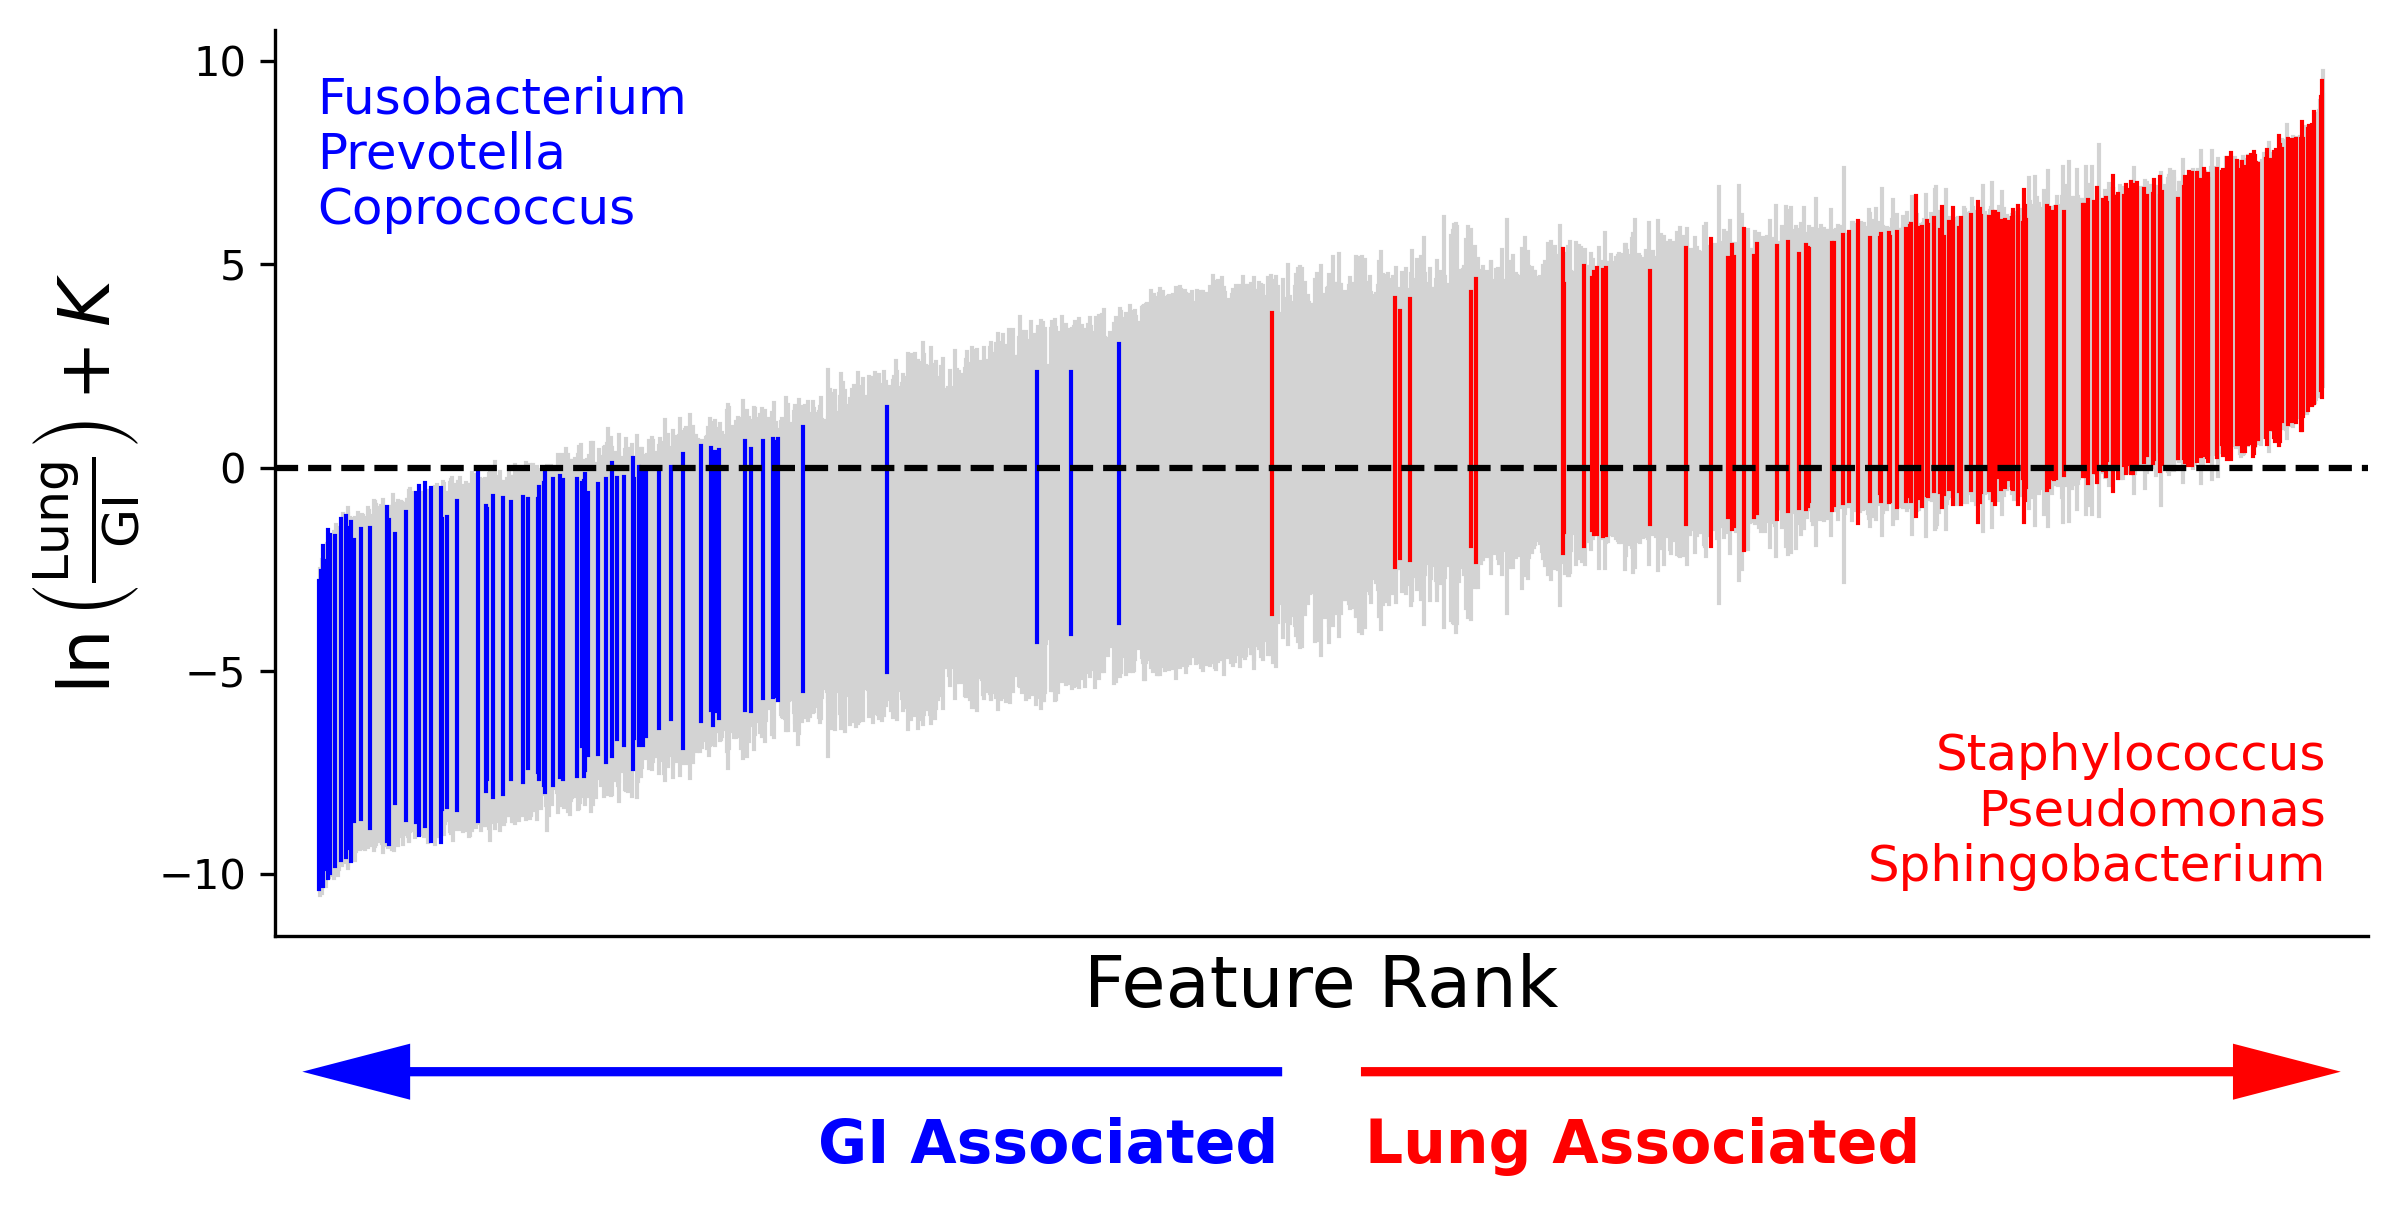

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(9, 4))

x = np.arange(lung_minus_gi.shape[0])

for i, (feature, row) in enumerate(lung_minus_gi.iterrows()):
    if row["Genus"] in gi_genera:
        color = "blue"
        zorder = 2
    elif row["Genus"] in lung_genera:
        color = "red"
        zorder = 2
    else:
        color="lightgray"
        zorder = 1
    ax.plot(
        [i, i],
        row[[0.05, 0.95]],
        linewidth=1,
        color=color,
        zorder=zorder
    )
    
ax.axhline(0, ls="--", color="black", zorder=4)
ax.set_xlabel("Feature Rank", fontsize="xx-large")
ax.set_ylabel(r"$\ln\left(\frac{\mathrm{Lung}}{\mathrm{GI}}\right) + K$", fontsize="xx-large")

text_args = {
    "transform": ax.transAxes,
    "fontsize": "large"
}
ax.text(
    s="\n".join([x.replace("g__", "") for x in gi_genera]),
    x=0.02,
    y=0.95,
    ha="left",
    va="top",
    color="blue",
    **text_args
)

ax.text(
    s="\n".join([x.replace("g__", "") for x in lung_genera]),
    x=0.98,
    y=0.05,
    ha="right",
    va="bottom",
    color="red",
    **text_args
)
ax.set_xticks([])
N = len(lung_minus_gi)
ax.set_xlim([-50, N + 50])

import matplotlib.transforms as transforms
tform = transforms.blended_transform_factory(ax.transData, ax.transAxes)

arrow_args = {
    "y": -0.15,
    "dy": 0,
    "clip_on": False,
    "transform": tform,
    "head_width": 0.05,
    "head_length": 100,
    "length_includes_head": True,
    "linewidth": 2
}
ax.arrow(
    x=N/2 - 50,
    dx=-N/2 + 50,
    color="blue",
    **arrow_args
)
ax.arrow(
    x=N/2 + 50,
    dx=N/2 - 50,
    color="red",
    **arrow_args
)

text_args = {
    "y": arrow_args["y"] - 0.05,
    "va": "top",
    "clip_on": False,
    "transform": tform,
    "fontsize": "x-large",
    "weight": "bold"
}
ax.text(
    x=N/2 - 50,
    s="GI Associated",
    ha="right",
    color="blue",
    **text_args
)

ax.text(
    x=N/2 + 50,
    s="Lung Associated",
    ha="left",
    color="red",
    **text_args
)

ax.yaxis.set_major_locator(ticker.MaxNLocator(5))

plt.savefig("../figures/tcga/lung_gi_ranks.pdf")
plt.show()

# Tsay

In [59]:
tsay_md = pd.read_table("../data/tcga/tsay_metadata.txt", index_col=0)
tsay_md

SampleID2   Sample_Type                    RACE  Male_1  \
SampleID                                                                      
770159.LLL         59.LLL.167  Airway.Brush                   White       2   
770159.RM           59.RM.167  Airway.Brush                   White       2   
770180.RLL     770180.RLL.170  Airway.Brush                   Asian       1   
770180.RM.170   770180.RM.170  Airway.Brush                   Asian       1   
770255.LLL         770255.LLL  Airway.Brush      Hispanic.or.Latino       1   
...                       ...           ...                     ...     ...   
VA041.RLL.2       VA041.RLL.2  Airway.Brush  Black.African.American       2   
VA048.RM             VA048.RM  Airway.Brush  Black.African.American       1   
VA048.RUL           VA048.RUL  Airway.Brush  Black.African.American       1   
VA050.LUL           VA050.LUL  Airway.Brush      Hispanic.or.Latino       1   
VA37.RM               VA37.RM  Airway.Brush  Black.African.American       1   

              Simple_Path Simple_Path_lns Advanced_Stage_label Simple_Outcome  \
SampleID                                                                        
770159.LLL          Adeno           NSCLC              Advance           dead   
770159.RM           Adeno           NSCLC              Advance           dead   
770180.RLL          Adeno           NSCLC                Local          alive   
770180.RM.170       Adeno           NSCLC                Local          alive   
770255.LLL          Adeno           NSCLC                Local          alive   
...                   ...             ...                  ...            ...   
VA041.RLL.2    Small.cell      Small.cell                Local          alive   
VA048.RM            Adeno           NSCLC                Local          alive   
VA048.RUL           Adeno           NSCLC                Local          alive   
VA050.LUL        Squamous           NSCLC              Advance          alive   
VA37.RM        Small.cell      Small.cell              Advance           dead   

              Simple_Outcome1 Smoking_status                    Pack_Years  \
SampleID                                                                     
770159.LLL               dead         Former                             5   
770159.RM                dead         Former                             5   
770180.RLL              alive         Former                            30   
770180.RM.170           alive         Former                            30   
770255.LLL              alive        Current                          25.5   
...                       ...            ...                           ...   
VA041.RLL.2             alive        Current                            20   
VA048.RM                alive        Current                            25   
VA048.RUL               alive        Current                            25   
VA050.LUL               alive         Former                           120   
VA37.RM                  dead        Current  1ppd..unclear.how.many.years   

               sixmonth.outcome.known1 death.less.6month1 death.less.1year  \
SampleID                                                                     
770159.LLL                           1                  0                0   
770159.RM                            1                  0                0   
770180.RLL                           1                  0                0   
770180.RM.170                        1                  0                0   
770255.LLL                           1                  0                0   
...                                ...                ...              ...   
VA041.RLL.2                          1                  0              n.a   
VA048.RM                             1                  0              n.a   
VA048.RUL                            1                  0              n.a   
VA050.LUL                            1                  0        

In [60]:
advanced_stage_samps = tsay_md.query("Advanced_Stage_label == 'Advance'")["SampleID2"]
len(advanced_stage_samps)

102

In [61]:
tsay_tbl = biom.load_table("../data/tcga/tsay_otu_table.txt").to_dataframe()
tsay_tbl.shape

(11353, 210)

In [62]:
advanced_tbl = tsay_tbl[advanced_stage_samps]
advanced_tbl = advanced_tbl.loc[advanced_tbl.sum(axis=1) != 0]
advanced_tbl.index = advanced_tbl.index.astype(str)
advanced_tbl.shape

(5836, 102)

In [63]:
tsay_tax = pd.read_table("../data/tcga/tsay_tax_table.txt", sep="\t", index_col=0)
tsay_tax = tsay_tax["taxonomy"].str.split("; ", expand=True)
tsay_tax.columns = list("kpcofgs")
tsay_tax.index = tsay_tax.index.astype(str)
tsay_tax = tsay_tax.loc[advanced_tbl.index]
tsay_tax.head()

k                  p                       c  \
4479944  k__Bacteria  p__Actinobacteria            c__MB-A2-108   
1050608  k__Bacteria  p__Actinobacteria       c__Actinobacteria   
333731   k__Bacteria  p__Actinobacteria      c__Thermoleophilia   
130468   k__Bacteria      p__Firmicutes              c__Bacilli   
185100   k__Bacteria  p__Proteobacteria  c__Deltaproteobacteria   

                              o                      f                   g  \
4479944            o__0319-7L14                    f__                 g__   
1050608      o__Actinomycetales  f__Corynebacteriaceae  g__Corynebacterium   
333731   o__Solirubrobacterales                    f__                 g__   
130468       o__Lactobacillales    f__Lactobacillaceae    g__Lactobacillus   
185100     o__Bdellovibrionales  f__Bacteriovoracaceae                 g__   

           s  
4479944  s__  
1050608  s__  
333731   s__  
130468   s__  
185100   s__

In [64]:
tsay_lung_genera = set([x for x in tsay_tax["g"].unique() if x != "g__"])

In [65]:
tcga_lung_samples = md[md["investigation"].isin(lung_cancers)].index
lung_tbl = tbl.filter(tcga_lung_samples, inplace=False)
lung_tbl.remove_empty()

1738 x 88 <class 'biom.table.Table'> with 24129 nonzero entries (15% dense)

In [66]:
tcga_lung_features = lung_tbl.ids("observation")
tcga_lung_genera = set([x for x in tax.loc[tcga_lung_features]["Genus"].unique() if x != "g__"])

In [67]:
len(tcga_lung_genera), len(tsay_lung_genera), len(tcga_lung_genera.intersection(tsay_lung_genera))

(491, 469, 201)

In [68]:
top_lung_genera = set(lung_minus_gi.sort_values(by=0.5, ascending=False).head(100)["Genus"].unique())
top_lung_genera.remove("g__")

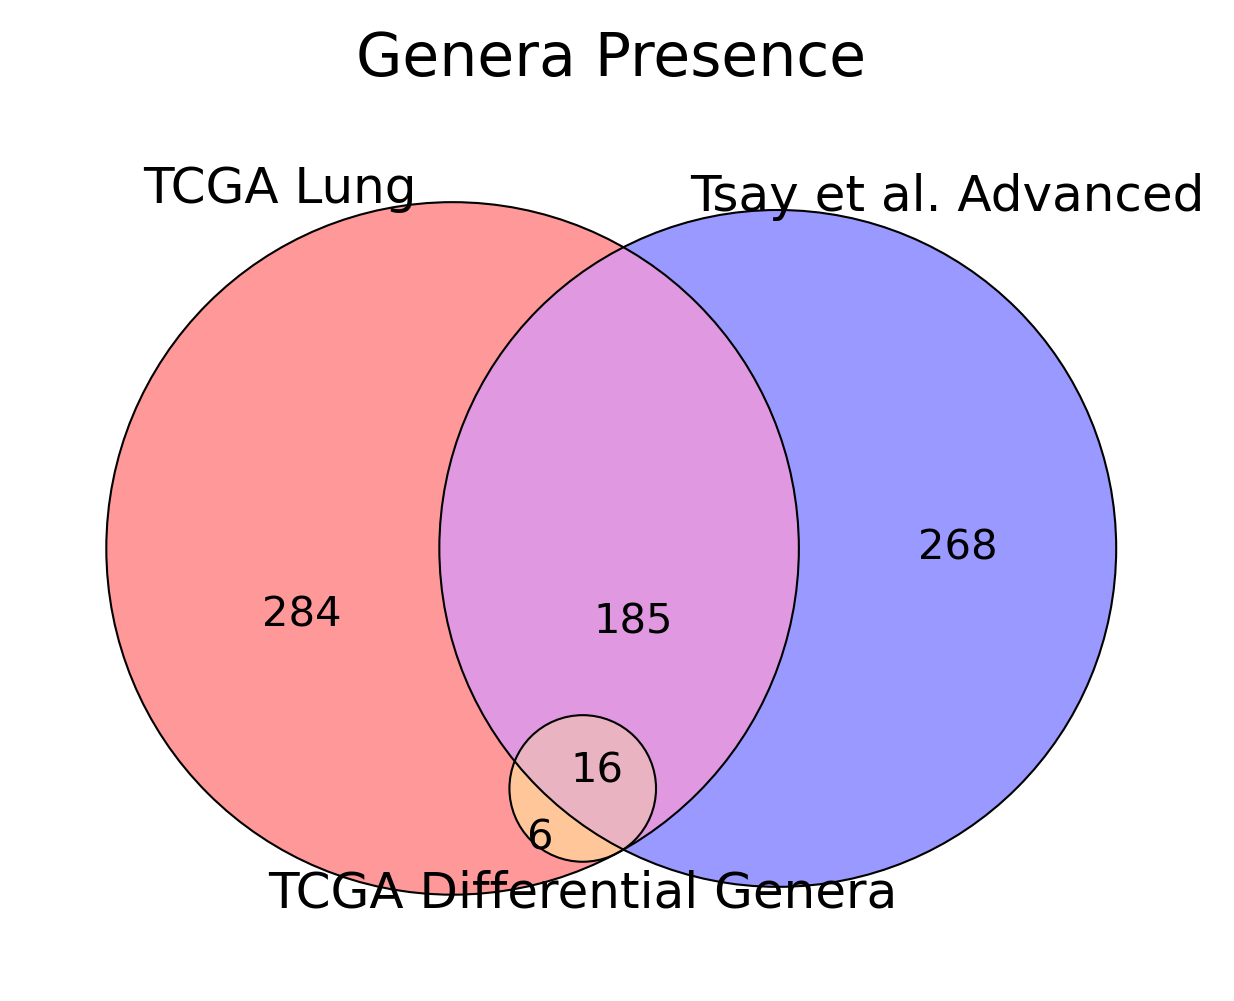

In [69]:
from matplotlib_venn import venn3, venn3_circles

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

v = venn3(
    [tcga_lung_genera, tsay_lung_genera, top_lung_genera],
    set_colors=["r", "b", "orange"],
    set_labels=["TCGA Lung", "Tsay et al. Advanced", "TCGA Differential Genera"],
    ax=ax
)

venn3_circles(
    [tcga_lung_genera, tsay_lung_genera, top_lung_genera],
    linewidth=0.5,
    ax=ax
)

for text in v.set_labels:
    if text is not None:
        text.set_horizontalalignment("center")
        
ax.set_title("Genera Presence", loc="center", y=1.03)

plt.savefig("../figures/tcga/lung_genera_venn.pdf")
plt.show()